## Miscentering Analysis: Matching cosmoDC2 Halos to redMaPPer Clusters
### Aidan Cloonan

**Note:** After importing, scroll down to the "Diagnostic Plots" heading in order to look at results.

This is an attempt to adapt methods from Zhang, *et al*. (2020) on Buzzard N-body simulations to cosmoDC2 simulation data. From within the data, clusters from the redMaPPer algorithm are paired with individual halos through constraints on halo mass, redshift, and angular separation. Basically

In [11]:
# compile cosmoDC2 data
#import GCRCatalogs as gcr

# math
import numpy as np

# plotting
import matplotlib.pyplot as plt
#from tools.plot_utils import plot_pretty
#plot_pretty()

# setup notebook for inline figures
%matplotlib inline

# track progress of loops
from tqdm import *
import time

import pickle

# astropy packages
import astropy.io.fits as fits                      # fits files
from astropy.table import Table                     # organize data into astropy tables
from astropy.coordinates import SkyCoord            # coordinates
from astropy import units as u                      # units
from astropy.cosmology import FlatLambdaCDM         # cosmological parameters and calculations

In [4]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    #plt.rc('text', usetex=True)
    
plot_prettier()

In [5]:
# define the cosmology
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)

In [4]:
gcr.get_available_catalog_names(include_default_only=False)

['base5000_v1.1.1',
 'base5000_v1.1.1_9431_9812',
 'base5000_v1.1.1_9556',
 'base5000_v1.1.1_image',
 'base5000_v1.1.1_small',
 'base5000_v1.1.1_z_0_1',
 'base5000_v1.1.1_z_1_2',
 'baseDC2_snapshot_z0.15_v0.1',
 'baseDC2_snapshot_z0.15_v0.1_small',
 'baseDC2_snapshot_z1.01_v0.1',
 'baseDC2_v1.1_9431_9812',
 'baseDC2_v1.1_9556',
 'baseDC2_v1.1_image',
 'buzzard',
 'buzzard_high-res',
 'buzzard_high-res_v1.1',
 'buzzard_test',
 'buzzard_v2.0.0_3',
 'buzzard_v2.0.0_4',
 'buzzard_v2.0.0_test',
 'cosmoDC2',
 'cosmoDC2_v1.0',
 'cosmoDC2_v1.0_10194_10452',
 'cosmoDC2_v1.0_8786_9049',
 'cosmoDC2_v1.0_9050_9430',
 'cosmoDC2_v1.0_9431_9812',
 'cosmoDC2_v1.0_9556',
 'cosmoDC2_v1.0_9813_10193',
 'cosmoDC2_v1.0_image',
 'cosmoDC2_v1.0_image_addon_knots',
 'cosmoDC2_v1.0_small',
 'cosmoDC2_v1.1.4',
 'cosmoDC2_v1.1.4_image',
 'cosmoDC2_v1.1.4_image_addon_knots',
 'cosmoDC2_v1.1.4_image_combined_agn',
 'cosmoDC2_v1.1.4_image_with_photoz_calib',
 'cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1',
 'co

In [6]:
# get the cosmoDC2 catalog
cosmoDC2_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_image')

# dc2 catalog
#cosmoDC2_gcr = gcr.load_catalog('dc2_object_run2.2i_dr6')

### Compile Cluster Data

From `redM_gcr`, where redMaPPer is applied to cosmoDC2.

In [8]:
# list all redMaPPer quantities
#redM_quantities = redM_gcr.list_all_quantities()
#print("All redMaPPer quantities:\n")
#print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
#cluster_quantities = [q for q in redM_quantities if 'member' not in q]
#print("\nCluster quantities:\n")
#print(cluster_quantities)

NameError: name 'redM_quantities' is not defined

In [8]:
# read in the cluster data
redM_data = Table(redM_gcr.get_quantities(cluster_quantities))

In [9]:
redM_data['richness']

<Column name='richness' dtype='float32' length=2796>
177.87721
160.45604
124.33225
99.283585
105.46185
127.03239
  94.4325
  71.5653
68.743126
 67.01932
 68.56007
 76.44689
      ...
20.735723
21.223883
24.579977
23.252794
  20.2018
21.986631
22.123926
23.512129
21.071333
 23.14601
51.108376
22.856165

In [10]:
# how many clusters are there in redMaPPer?
assert len(redM_data['redshift']) == len(redM_data['cluster_id']) == len(redM_data['ra']) == len(redM_data['dec'])
print("There are {} clusters in the cosmoDC2 redMaPPer algorithm.".format(len(redM_data)))

There are 2796 clusters in the cosmoDC2 redMaPPer algorithm.


#### ALTERNATIVE: Retrieve from Global Files

There are FITS tables of cosmoDC2 redMaPPer results stored in the global NERSC files. Instead of retrieving using GCRCatalogs, we can get the cluster data from these tables.

In [8]:
def read_redM_fits(filename):
    '''
    reads and returns data from a FITS file
    '''
    hdu = fits.open(filename)
    data = Table(hdu[1].data)   # second index of the hdu corresponds to the data in these table files
    hdu.close()
    
    return data

# cosmoDC2 redMaPPer v0.7.5
#redM_file = '/global/cfs/projectdirs/lsst/shared/xgal/cosmoDC2/addons/redmapper_v1.1.4/cosmoDC2_v1.1.4_mag_run_redmapper_v0.7.5_lgt20_catalog.fit'

# redmapper file
redM_file = '/global/cfs/projectdirs/lsst/shared/xgal/cosmoDC2/addons/redmapper_v1.1.4/cosmoDC2_v1.1.4_mag_run_redmapper_v0.8.1_lgt05_catalog_members.fit'
#redM_file = '/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/redmapper/dr6-wfd/dc2_dr6_run_redmapper_v0.8.1_lgt20_vl50_catalog.fit'

#########

# BEFORE RUNNING THIS, FIND THE CORRECT HALOS CATALOG

#########

redM_data = read_redM_fits(redM_file)
redM_data
#redM_data = redM_data[redM_data['lambda'] >= 5]
#print("There are {} clusters in the cosmoDC2 redMaPPer algorithm.".format(len(redM_data['lambda'])))

<Table length=887518>
mem_match_id      id     ...        mag [5]                mag_err [5]        
   int32        int64    ...        float32                  float32          
------------ ----------- ... ---------------------- --------------------------
          10  1312945563 ... 20.286411 .. 17.322586 0.009603887 .. 0.010201863
          10  1312932492 ...    20.368668 .. 17.482 0.012352037 .. 0.009908532
          10  1312932655 ...  22.91745 .. 19.879288  0.01891223 .. 0.017637273
          10  1312946401 ...   23.4083 .. 20.473616 0.027896943 .. 0.021821225
          10  1312946359 ... 22.737461 .. 19.697416 0.016593894 .. 0.019811315
          10  1312932712 ... 22.236683 .. 19.213097 0.016813552 .. 0.015494846
          10  1312945743 ... 22.867363 .. 19.805065 0.024009278 .. 0.025163647
          10  1312932517 ...  23.20681 .. 20.161732 0.028785601 .. 0.019997919
          10  1312946270 ...  22.93172 .. 19.981861      0.024148 .. 0.0201497
          10  1312946366 ... 23.487461 .. 20.598295   0.0216804 .. 0.022545338
         ...         ... ...                    ...                        ...
       74968 12001980394 ... 24.844208 .. 21.591358 0.041529465 .. 0.034154713
       74968 12001980397 ... 26.244192 .. 22.200325  0.07007078 .. 0.056781575
       74968 12002195458 ... 25.115776 .. 22.024704 0.046964042 .. 0.048263226
       74968 12001980408 ... 26.395853 .. 22.676394    0.0745093 .. 0.05683816
       74968 12001723737 ...  26.571117 .. 22.73902    0.13125814 .. 0.0671815
       74968 12001566320 ...  26.151848 .. 22.76169   0.12304669 .. 0.09619413
       74968 12001731074 ... 24.863094 .. 21.283115 0.043481283 .. 0.036398366
       74968 12001996934 ...  24.721514 .. 21.12131   0.03580071 .. 0.03486036
       74968 12001996929 ... 26.070425 .. 22.449701  0.06755786 .. 0.047748793
       74968 12000039772 ...  22.81131 .. 21.352406  0.017734144 .. 0.03392108

In [9]:
print(np.min(redM_data['dec']), np.max(redM_data['dec']))

-44.492357759053036 -27.089863733508555


### Compile Halo Data

From `cosmoDC2_gcr`, which includes all data from the cosmoDC2 simulation. There are 2256249331 galaxies in the entire catalog.

In [13]:
for i in cosmoDC2_gcr.list_all_quantities():
    if 'gal' in i:
        print(i)

galaxy_id


In [14]:
# list wanted halo quantities, with a filter on halo_mass
halo_quantities_wanted = ['halo_mass'
                          , 'halo_id'
                          , 'redshift'
                          , 'ra'
                          , 'dec'
                          , 'galaxy_id']
query = gcr.GCRQuery('halo_mass > 1e13')

In [15]:
# read in the halo data
halos_data = Table(cosmoDC2_gcr.get_quantities(halo_quantities_wanted, [query]))

In [16]:
# filter out duplicate halos
unique_ID, unique_ind = np.unique(halos_data['halo_id'], return_index=True)
filtered_halos_data = halos_data[unique_ind]
print ("There are {} unique halos in the dataset.".format(len(filtered_halos_data)))

There are 471966 unique halos in the dataset.


In [17]:
# check that there aren't duplicate galaxy IDs in the filtered data
unique_gal, unique_gal_ind = np.unique(filtered_halos_data['galaxy_id'], return_index=True)
print("There are {} duplicate galaxy IDs in the filtered data.".format(len(filtered_halos_data) - len(unique_gal_ind)))

There are 0 duplicate galaxy IDs in the filtered data.


In [18]:
# write so we don't have to compile again
filtered_halos_data.write("filtered_halos.fits", format='fits')

In [15]:
halos_data = read_redM_fits('filtered_halos.fits')

### Scatterplot of Simulated Positions of Halos and Clusters

This lets us know that there are halos that can definitely be matched with clusters.

In [16]:
redM_data#[redM_data['lambda'] >= 20]

<Table length=2819>
mem_match_id         ra         ...            p_c [5]            
   int32          float64       ...            float32            
------------ ------------------ ... ------------------------------
           4  56.92037639745262 ...     0.9358046 .. 0.00023949727
          20  58.56361771817086 ...     0.9612172 .. 1.9531019e-05
          88  58.13480040126862 ...      0.4224148 .. 4.599504e-05
          84  55.77953698782553 ...    0.07608965 .. 1.1515751e-05
         125  56.78451609542386 ...     0.9722467 .. 0.00019764158
         127  57.75749190808748 ...   0.048298445 .. 5.2945532e-05
         162 56.706139947800125 ...     0.13122907 .. 5.114277e-08
         193  55.61792707925289 ...    0.86235285 .. 1.7093726e-05
         202  55.92198349554445 ...      0.609084 .. 5.5618533e-05
         281  55.72602161220604 ...     0.8304762 .. 1.1653832e-07
         ...                ... ...                            ...
        2080  68.77989102701024 ...  0.0021242935 .. 2.2652202e-08
        2875  68.06737279036327 ...    0.08693546 .. 7.5016874e-07
        2860   67.7112339672714 ...    0.47847393 .. 2.8060616e-05
        2968  68.33132215190956 ...      0.72177166 .. 0.003957335
        2586  69.86609321002138 ...   0.029205767 .. 3.6108486e-07
        3515  66.66828157969482 ...   0.085658014 .. 2.4226336e-05
        3768  66.41943572181938 ...    0.28062803 .. 1.3282956e-06
        4219  66.68414692683935 ...      0.7819189 .. 7.033825e-05
        5412  69.05831006008037 ...  0.094905816 .. 0.000116956435
        4450  67.35443113691774 ... 1.7965498e-05 .. 1.2726086e-07

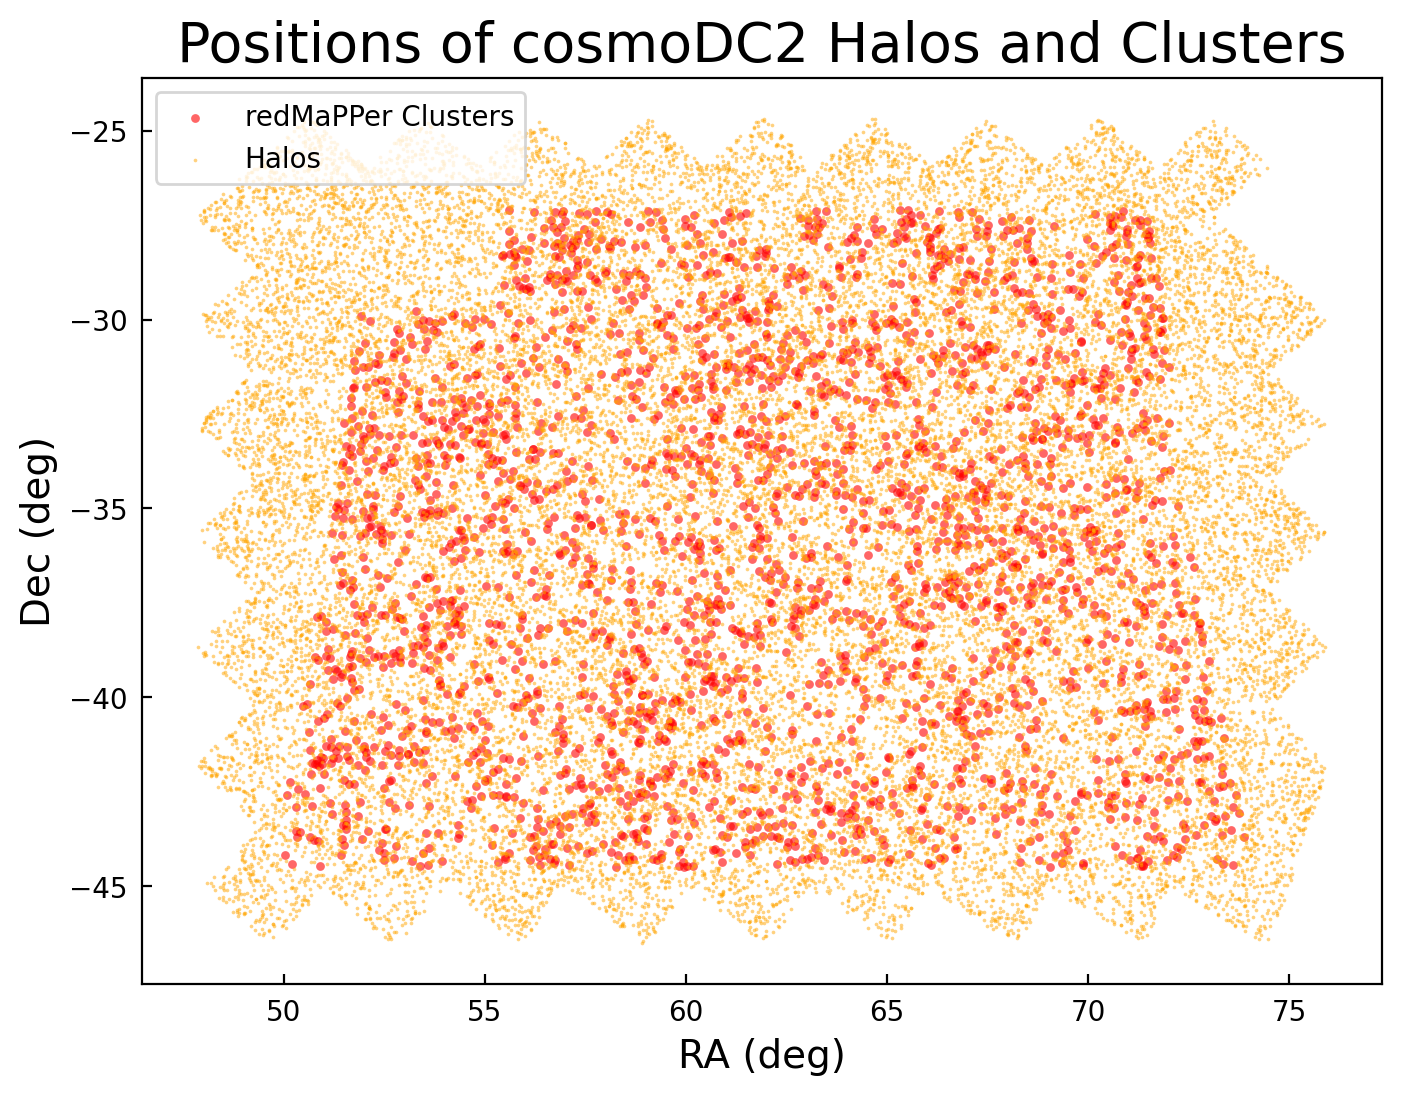

In [17]:
# Scatter plot to inspect that halos match clusters
plt.figure(figsize=(8,6))
plt.scatter(redM_data['ra'], redM_data['dec'], c='r', s=10, alpha=0.6, marker='o',linewidth=0.0, label='redMaPPer Clusters')
plt.scatter(filtered_halos_data['ra'][::15], filtered_halos_data['dec'][::15], c='orange', marker='.', s=7, linewidth=0.0, alpha=0.5, label='Halos')

plt.xlabel('RA (deg)', fontsize=14); plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of cosmoDC2 Halos and Clusters', fontsize=20)
#plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

### Extract Parameters from Table Files

In [24]:
# these ONLY work after extracting data and then saving it once

#redM_pkl = 'cosmoDC2_redM_cloonan_cut.pkl'
halos_pkl = 'halos_cloonan_cut.pkl'

#with open(redM_pkl, 'rb') as inp:
#    redM_data = pickle.load(inp)
    
with open(halos_pkl, 'rb') as inp:
    halos_data = pickle.load(inp)

In [25]:
# define the cosmology
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)

In [26]:
halos_data_mcut = halos_data[halos_data['M'] > 5e13]
print(len(halos_data_mcut))
print(len(halos_data))

redM_data = redM_data[redM_data['lambda'] >= 20]
print(len(redM_data))

31959
471966
2819


In [27]:
halos_data.columns

<TableColumns names=('ID','RA','Dec','z','M','comvd')>

In [28]:
# clusters
redM_id = redM_data['mem_match_id']
redM_ra = redM_data['ra']; redM_dec = redM_data['dec']
redM_z = redM_data['z']
redM_lambda = redM_data['lambda']

# halos
halos_id = halos_data['ID']
halos_ra = halos_data['RA']; halos_dec = halos_data['Dec']
halos_z = halos_data['z']
halos_mass = halos_data['M']

# extract comoving distance
redM_comvd = cosmo.comoving_distance(redM_z).value
halos_comvd = cosmo.comoving_distance(halos_z).value

In [29]:
redM_data['comvd'] = redM_comvd ##Add the comoving distance column


In [30]:
##Creating Tables.
halos_data = Table([halos_id, halos_ra, halos_dec, halos_z, halos_mass, halos_comvd], names = ('ID', 'RA', 'Dec', 'z', 'M', 'comvd'))

In [31]:
halos_data_mcut = halos_data[halos_data['M'] > 5e13]
print(len(halos_data_mcut))
print(len(halos_data))

redM_data = redM_data[redM_data['lambda'] >= 20]
print(len(redM_data))

31959
471966
2819


### Saving with Pickle

In [32]:
##pickle the class object for storage
import pickle
with open('halos_cloonan_cut.pkl', 'wb') as outp:
    pickle.dump(halos_data, outp, pickle.HIGHEST_PROTOCOL)
    
with open('dr6dc2_redM_cloonan_cut.pkl', 'wb') as outp:
    pickle.dump(redM_data, outp, pickle.HIGHEST_PROTOCOL)

### Matching Test: Angular Separation

For each cluster, find the halo of least angular separation, using a sample of the redMaPPer clusters.

In [33]:
# using find_nearest_halo, iterate through array and find index of matches
# go through the richness-mass template finder

# define coordinates for clusters and halos
redM_coord = SkyCoord(redM_ra*u.deg, redM_dec*u.deg, frame='icrs')
halos_coord = SkyCoord(halos_ra*u.deg, halos_dec*u.deg, frame='icrs')

# define find_nearest_halo, which identifies the nearest halo neighbor for clusters
def find_nearest_halo(ind):
    dist_sep = halos_coord.separation(redM_coord[ind])
    index = np.abs(dist_sep).argmin()
    return index, dist_sep[index].value

In [34]:
# test find_nearest_halo on some indices in redM_coord
# each cluster should have a specific match

for i in range(50,70) :
    print(i, find_nearest_halo(i))

50 (255663, 2.969020044777557e-06)
51 (97777, 1.0325707045166737e-06)
52 (35873, 6.170379364019859e-05)
53 (25979, 3.5569831525703372e-06)
54 (410306, 0.007818488551682256)
55 (355149, 0.008744278996338891)
56 (93982, 8.754683793991787e-07)
57 (290182, 8.05274953753195e-06)
58 (37382, 2.3751495870771845e-06)
59 (144354, 3.917968054492814e-05)
60 (397093, 1.6175844817210564e-06)
61 (50730, 9.080442276428418e-06)
62 (371754, 2.1843367614413633e-06)
63 (343281, 0.008812658957176433)
64 (194845, 1.611851717697196e-05)
65 (120714, 0.017855591248364156)
66 (207918, 0.005115092094571102)
67 (112617, 3.6879389959497755e-06)
68 (151161, 6.716051818019139e-07)
69 (219486, 1.2564972015615956e-05)


In [35]:
# a distance definition that I used initially which I messed up
def distance_cloonan(redM_ra, redM_dec, halos_ra, halos_dec, halos_comvd):
    # use spherical law of cosines to find angle difference from RA, Dec
    d_lmda = redM_ra - halos_ra
    cosine = np.sin(redM_dec)*np.sin(halos_dec) + np.cos(redM_dec)*np.cos(halos_dec)*np.cos(d_lmda)
        
    if (np.abs(cosine) > 1) and (np.abs(cosine) - 1 < 1e-15):
        cosine = 1
            
    d_Sigma = np.arccos(cosine)
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * halos_comvd**2. * (1. - np.cos(d_Sigma)))
    return dist_cmv

In [36]:
redM_ind = 56
halos_ind, deg_sep = find_nearest_halo(redM_ind)
print(halos_ind)

dist_cloonan = distance_cloonan(redM_data['ra'][redM_ind], redM_data['dec'][redM_ind], halos_data['RA'][redM_ind], halos_data['Dec'][halos_ind], halos_data['comvd'][halos_ind])
print(dist_cloonan)

##Astropy separation code. 
c1 = SkyCoord(redM_data['ra'][redM_ind]*u.deg, redM_data['dec'][redM_ind]*u.deg, distance=redM_data['comvd'][redM_ind]*u.Mpc, frame='icrs')
c2 = SkyCoord(halos_data['RA'][halos_ind]*u.deg, halos_data['Dec'][halos_ind]*u.deg, distance=halos_data['comvd'][halos_ind]*u.Mpc, frame='icrs')
dist_astropy = c1.separation_3d(c2)

print(dist_astropy, deg_sep)

93982
2538.4920980775037
5.320129092514744 Mpc 8.754683793991787e-07


### Running Angular Separation Code for all redMaPPer Clusters


In [37]:
from astropy.table import Column

In [38]:
redM_matched = redM_data.copy()
len(redM_matched)

2819

In [39]:
##Adding columns
redM_matched['matched'] = False
redM_matched['centered'] = False

init_col = np.full(len(redM_matched), 0.0)

c = Column(init_col.astype(int), name='halo_ID')
redM_matched.add_column(c)

c = Column(init_col, name='halo_RA')
redM_matched.add_column(c)

c = Column(init_col, name='halo_Dec')
redM_matched.add_column(c)

c = Column(init_col, name='halo_z')
redM_matched.add_column(c)

c = Column(init_col, name='halo_M')
redM_matched.add_column(c)

c = Column(init_col, name='halo_comv')
redM_matched.add_column(c)

c = Column(init_col, name='propD_sep')
redM_matched.add_column(c)

c = Column(init_col, name='z_sep')
redM_matched.add_column(c)

In [40]:
# define the cosmology
# Honestly, I can't recall the source for this cosmology. Feel free to use a different one from the 
# literature, but of course you'll have to rerun the whole analysis. 
# But, that being said, this may have to be done anyway in order to fit into a broader paper.
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)

In [41]:
##Function to find match
def redM_match_halo(cosmo, z_sep_lim=0.05, cent_tol=1e-10):
    global redM_data
    global halos_data
    global redM_matched
    
    # define coordinates for clusters and halos
    redM_coord = SkyCoord(redM_data['ra']*u.deg, redM_data['dec']*u.deg, frame='icrs')
    
    for i in tqdm(range(len(redM_coord))):
        #Reset the variables
        matched = False
        centered = False
        
        mask = np.abs(halos_data['z'] - redM_data['z'][i]) < z_sep_lim
        halos_candidates = halos_data[mask]
        
        #coordinates after redshift cut
        halos_coord = SkyCoord(halos_candidates['RA']*u.deg, halos_candidates['Dec']*u.deg, frame='icrs')
        ang_sep = halos_coord.separation(redM_coord[i]).value #In degrees
        
        if any(ang_sep):
            matched = True
            index = np.abs(ang_sep).argmin()
            min_sep = ang_sep[index]
            halo_matched = halos_candidates[index]
            propD_sep = (cosmo.kpc_proper_per_arcmin(halos_candidates['z'][index])*min_sep*60).value
            z_sep = halos_candidates['z'][index] - redM_data['z'][i]
            
            if min_sep < cent_tol:
                centered = True
                
        else:
            matched = False
            centered = False
            halo_matched = [np.ma.masked for i in range(len(halos_data.columns))]
            propD_sep = np.ma.masked
            z_sep = np.ma_masked
        
        ##Modify the matched table
        redM_matched['matched'][i] = matched
        redM_matched['centered'][i] = centered
        redM_matched['halo_ID'][i] = halo_matched['ID']
        redM_matched['halo_RA'][i] = halo_matched['RA']
        redM_matched['halo_Dec'][i] = halo_matched['Dec']
        redM_matched['halo_z'][i] = halo_matched['z']
        redM_matched['halo_M'][i] = halo_matched['M']
        redM_matched['halo_comv'][i] = halo_matched['comvd']
        redM_matched['propD_sep'][i] = propD_sep
        redM_matched['z_sep'][i] = z_sep
        
    return

In [42]:
redM_match_halo(cosmo)

100%|██████████| 2819/2819 [00:45<00:00, 62.21it/s]


In [44]:
##Check if there are unmatched clusters
if not np.ma.getmask(redM_matched['halo_ID']):
    print("All clusters matched")
else:
    print("Number of matched clusters {}".format(redM_matched['halo_ID'].count()))
          
#number of centered clsuters
print("No. centered clusters: {}".format(len(np.where(redM_matched['centered'])[0]) ) )

#number of miscentered clsuters
print("No. miscentered clusters: {}".format(len(np.where(redM_matched['centered']==False)[0]) ) )

All clusters matched
No. centered clusters: 0
No. miscentered clusters: 2819


In [46]:
redM_cent = redM_matched[redM_matched['centered'] == True]
redM_miscent = redM_matched[redM_matched['centered'] == False]

In [47]:
# save redM_matched

with open('dr6dc2_matched_cloonan.pkl', 'wb') as outp:
    pickle.dump(redM_matched, outp, pickle.HIGHEST_PROTOCOL)

At this point, the main objective of this notebook is basically complete. RedMaPPer clusters have been paired with simulated dark matter halos, and they have all been identified as either *centered* or *miscentered*.

### Diagnosis Plots for Centered Halos and Clusters

#### Halo Mass Distribution

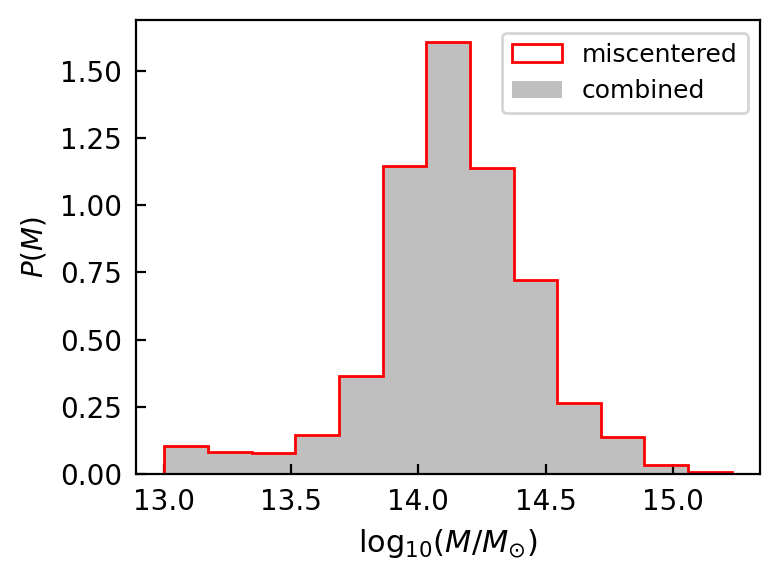

In [49]:
###This is how I would plot it
plt.figure(figsize=(4,3), tight_layout=True)
#plt.hist(np.log10(redM_cent['halo_M']), bins='sturges', density=True, histtype='step', fill=False, color='blue', label='centered')
plt.hist(np.log10(redM_miscent['halo_M']), bins='sturges', density=True, histtype='step', fill=False, color='red', label='miscentered')
plt.hist(np.log10(redM_matched['halo_M']), bins='sturges', density=True, alpha=0.5, color='grey', label='combined')
plt.xlabel(r'$\log_{10}({M/M_{\odot}})$', fontsize=11)
plt.ylabel(r'$P(M)$')
plt.legend(fontsize=9, loc='best')
plt.show()

#### Distribution of Redshift Difference

Note the cutoff at $\Delta{z} = 0.05$.

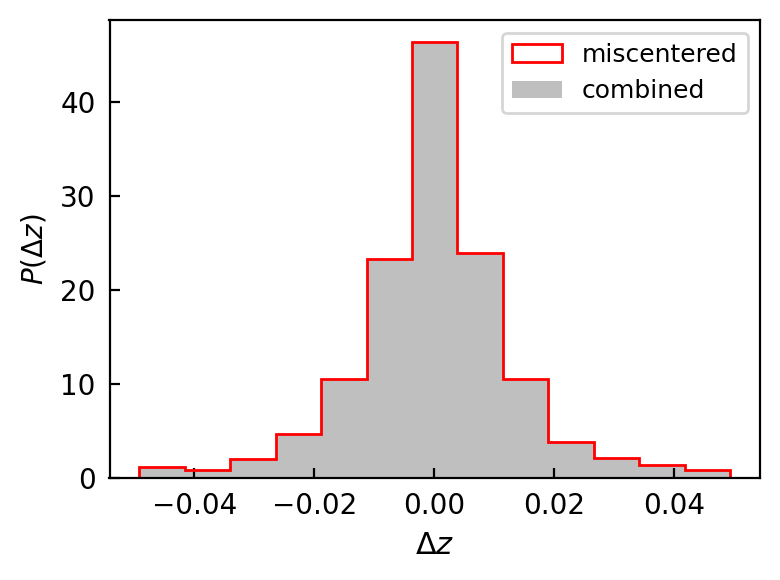

In [50]:
###This is how I would plot it
plt.figure(figsize=(4,3), tight_layout=True)
#plt.hist(redM_cent['z_sep'], bins='sturges', density=True, histtype='step', fill=False, color='blue', label='centered')
plt.hist(redM_miscent['z_sep'], bins='sturges', density=True, histtype='step', fill=False, color='red', label='miscentered')
plt.hist(redM_matched['z_sep'], bins='sturges', density=True, alpha=0.5, color='grey', label='combined')
plt.xlabel(r'$\Delta z$', fontsize=11)
plt.ylabel(r'$P(\Delta z)$')
plt.legend(fontsize=9, loc='best')
plt.show()

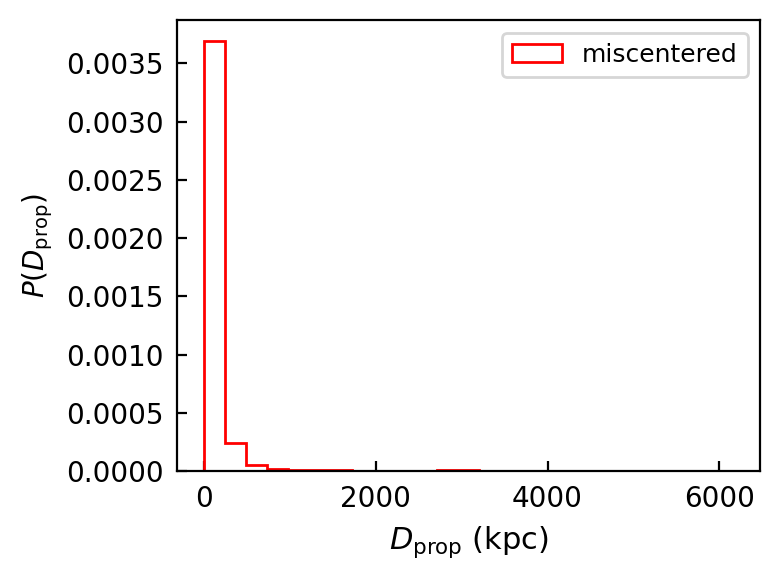

In [51]:
###This is how I would plot it
plt.figure(figsize=(4,3), tight_layout=True)
#plt.hist(redM_cent['propD_sep'], 15, density=True, histtype='step', fill=False, color='blue', label='centered')
plt.hist(redM_miscent['propD_sep'], 25, density=True, histtype='step', fill=False, color='red', label='miscentered')
#plt.hist(redM_matched['propD_sep'], 15, density=True, alpha=0.5, color='grey', label='combined')
plt.xlabel(r'$D_{\rm prop}$ (kpc)', fontsize=11)
plt.ylabel(r'$P(D_{\rm prop})$')
plt.legend(fontsize=9, loc='best')
plt.show()

### Plotting Richness-Mass

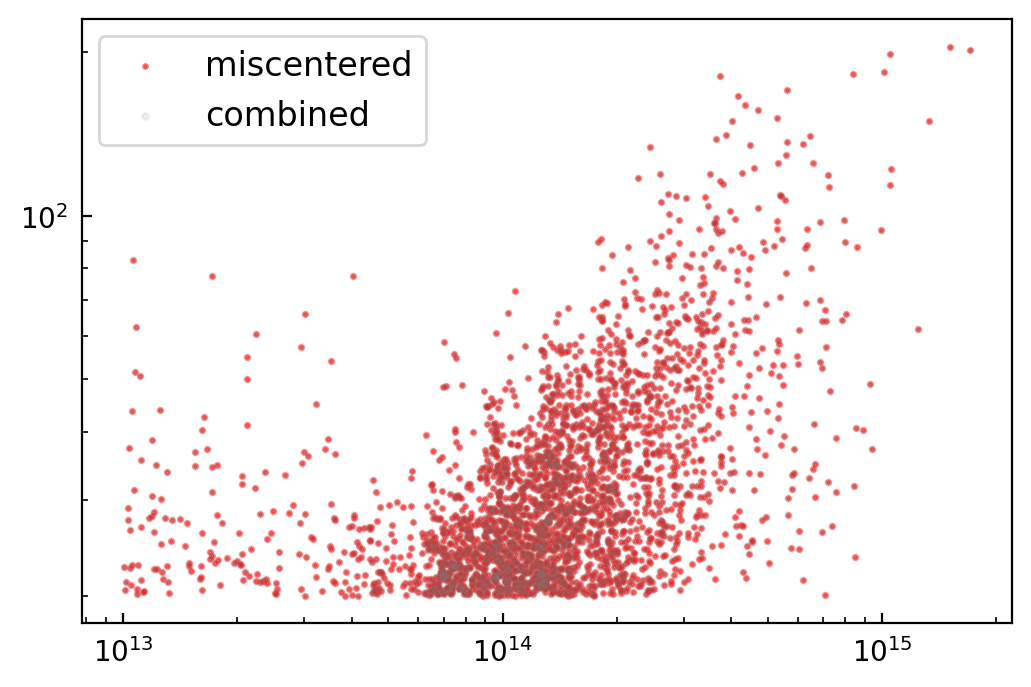

In [52]:
## Plot richness-mass
plt.figure(figsize=(6,4))
#plt.scatter(redM_cent['halo_M'], redM_cent['lambda'], c='b', alpha=0.5,s=1, label='centered')
plt.scatter(redM_miscent['halo_M'], redM_miscent['lambda'], c='r', alpha=0.5,s=2, label='miscentered')
plt.scatter(redM_matched['halo_M'], redM_matched['lambda'],  c='grey', alpha=0.1,s=5, label='combined')
plt.legend(loc='upper left', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.show()

### Cross Examine Matching with CLEVAR

In [4]:
from clevar.catalog import ClCatalog
from clevar.catalog import MemCatalog
from clevar.match import MembershipMatch
from clevar.match_metrics import recovery
from clevar.match_metrics import distances
from clevar.match_metrics import scaling

ModuleNotFoundError: No module named 'healpy'

In [ ]:
from clevar.match import ProximityMatch
mt = ProximityMatch()

In [ ]:
c1 = ClCatalog('redM', id=redM_data['mem_match_id'], ra=redM_data['ra'], dec=redM_data['dec'], mass=redM_data['lambda'], z=redM_data['z'])
c2 = ClCatalog('halo', id=halos_data['ID'], ra=halos_data['RA'], dec=halos_data['Dec'], mass=halos_data['M'],z=halos_data['z'])

In [ ]:
from clevar.cosmology import AstroPyCosmology
clevar_cosmo = AstroPyCosmology()

In [ ]:
%%time
mt.match_from_config(c1, c2, match_config, cosmo=clevar_cosmo)

In [ ]:
info = scaling.mass_density_metrics(
    c2, c1, 'cross', ax_rotation=45,
    add_fit=True, fit_bins1=8)

In [ ]:
info = scaling.mass_density_metrics(
    c1, c2, 'cross', ax_rotation=45,
    add_fit=True, fit_bins1=8)

#### Distribution of Angular Separation

Note the cutoff at $\Delta{\theta} = 10^{-5}$ degrees.

Text(0.5, 1.0, 'Distribution of Angular Separation')

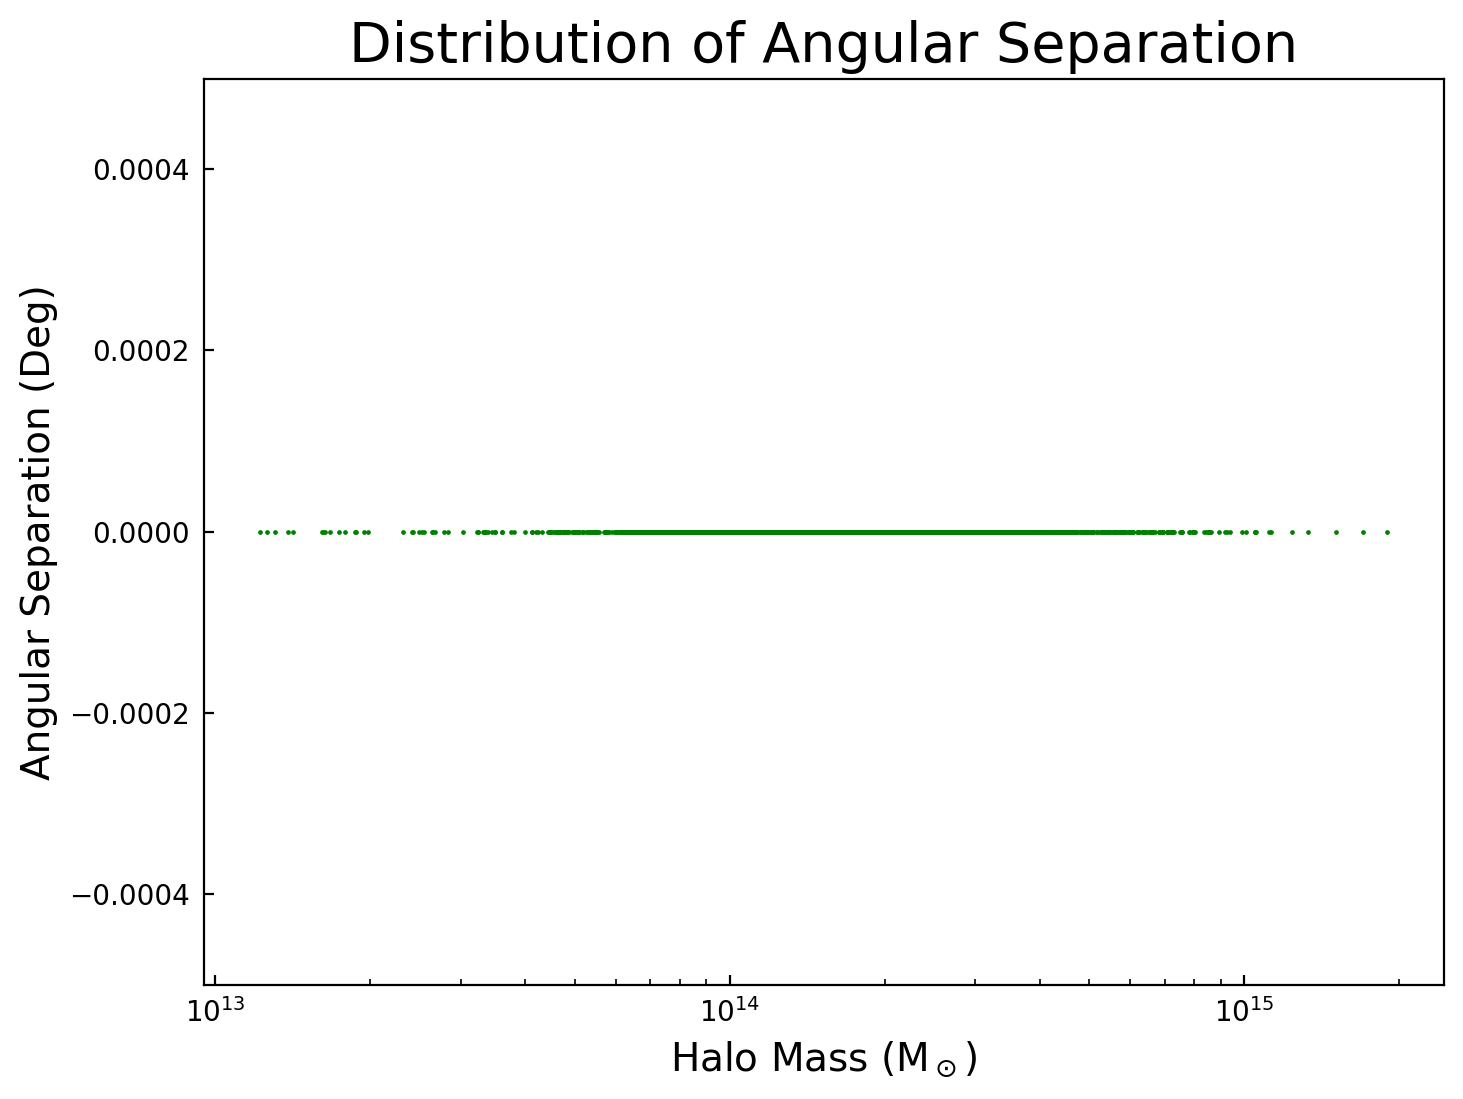

In [20]:
ang_sep = np.sqrt((halos_cent['ra'] - redM_cent['ra'])**2 + (halos_cent['dec']-redM_cent['dec'])**2)

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], ang_sep, s=0.5, c='g')
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Angular Separation (Deg)', fontsize=14)
plt.ylim(-0.0005, 0.0005)
plt.title('Distribution of Angular Separation', fontsize=20)

#### Distribution of Comoving Distance Separation

In [134]:
plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], dcmv_sep_cent, s=0.75, c='g')
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'$d_{\rm cmv}$ ($\rm{Mpc}$ $h^{-1}$)', fontsize=14)
plt.xlim(9e12, 2e15)
plt.ylim(-0.00001, 0.0001)
plt.title('Comoving Distance Separation', fontsize=20)

NameError: name 'halos_cent' is not defined

<Figure size 1600x1200 with 0 Axes>

#### $\log(\lambda)$-$\log(M)$ Relation

3751


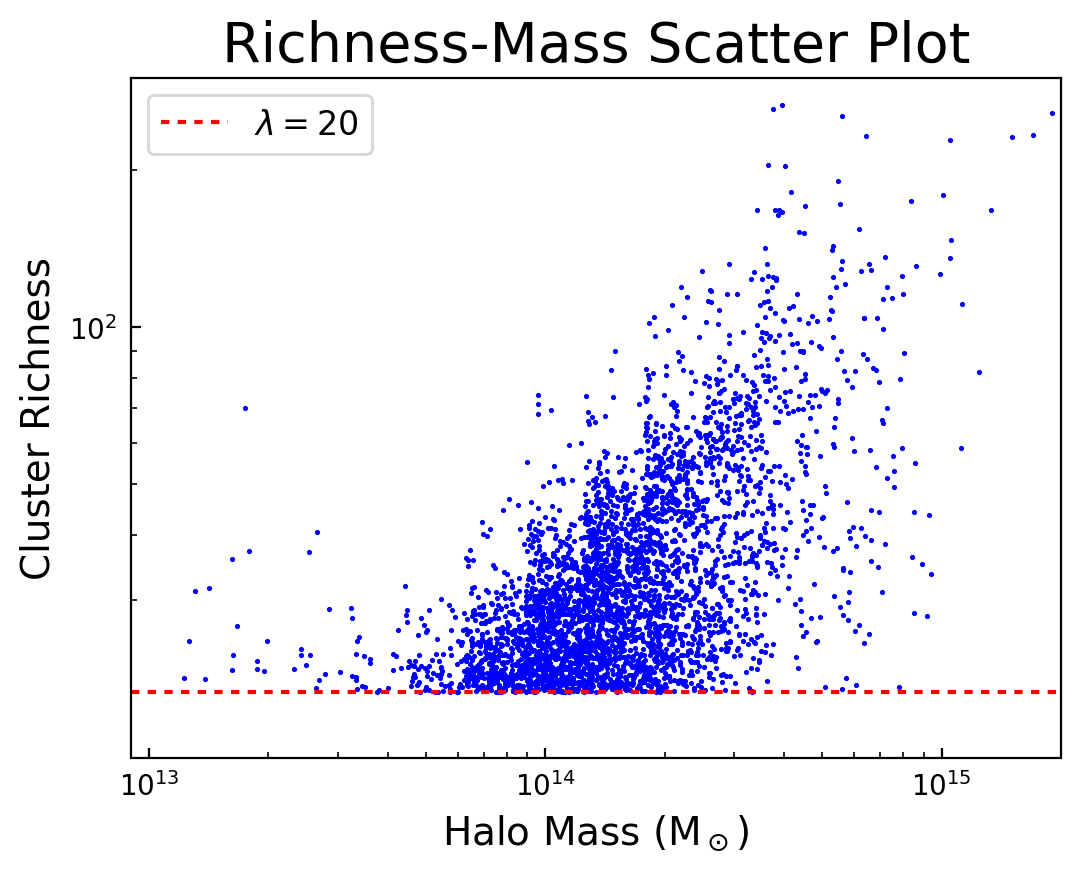

In [22]:
x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

print(len(np.where(redM_cent['lambda'] >= 0)[0]))

plt.figure(figsize=(6, 4.5))
plt.scatter(halos_cent['halo_mass'], redM_cent['lambda'], s=0.75, c='b')
plt.plot(x,y,':r', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass Scatter Plot', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

### Matching Miscentered Halos and Clusters

Centered clusters are automatically assigned a halo. This algorithm will apply to miscentered clusters.

There are some trigonometric calculations involved in this. As a result, we need to convert the RA and Dec values into radians.

First, though, we'll need to define the cosmology according to the parameters outlined [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

**Note**: I did not account for the cosmology of the cosmoDC2 simulation during my first few runs of this notebook, but I just used that of WMAP9. I should run this again with a more accurate cosmology, defined below. That being said, I'll need to figure out how to account for $\sigma_{8} = 0.8$ and $n_{s} = 0.963$.

In [23]:
# define the cosmology
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)

In [24]:
# extract parameters again, but only for miscentered clusters and halos

# skip first step if running on dr6, so all labeled as miscentered
if 'dr6' in redM_file:
    redM_miscent = np.array(redM_data)
    halos_miscent = np.array(filtered_halos_data)

# clusters
mredM_id = redM_miscent['mem_match_id']
mredM_ra = redM_miscent['ra'] * np.pi/180;        # CONVERT TO RADIANS
mredM_dec = redM_miscent['dec'] * np.pi/180       # CONVERT TO RADIANS
mredM_z = redM_miscent['z']
mredM_lambda = redM_miscent['lambda']

# halos
mhalos_id = halos_miscent['halo_id']
mhalos_ra = halos_miscent['ra'] * np.pi/180;      # CONVERT TO RADIANS
mhalos_dec = halos_miscent['dec'] * np.pi/180     # CONVERT TO RADIANS
mhalos_z = halos_miscent['redshift']
mhalos_mass = halos_miscent['halo_mass']

# extract comoving distance
mredM_comvd = cosmo.comoving_distance(mredM_z).value
mhalos_comvd = cosmo.comoving_distance(mhalos_z).value

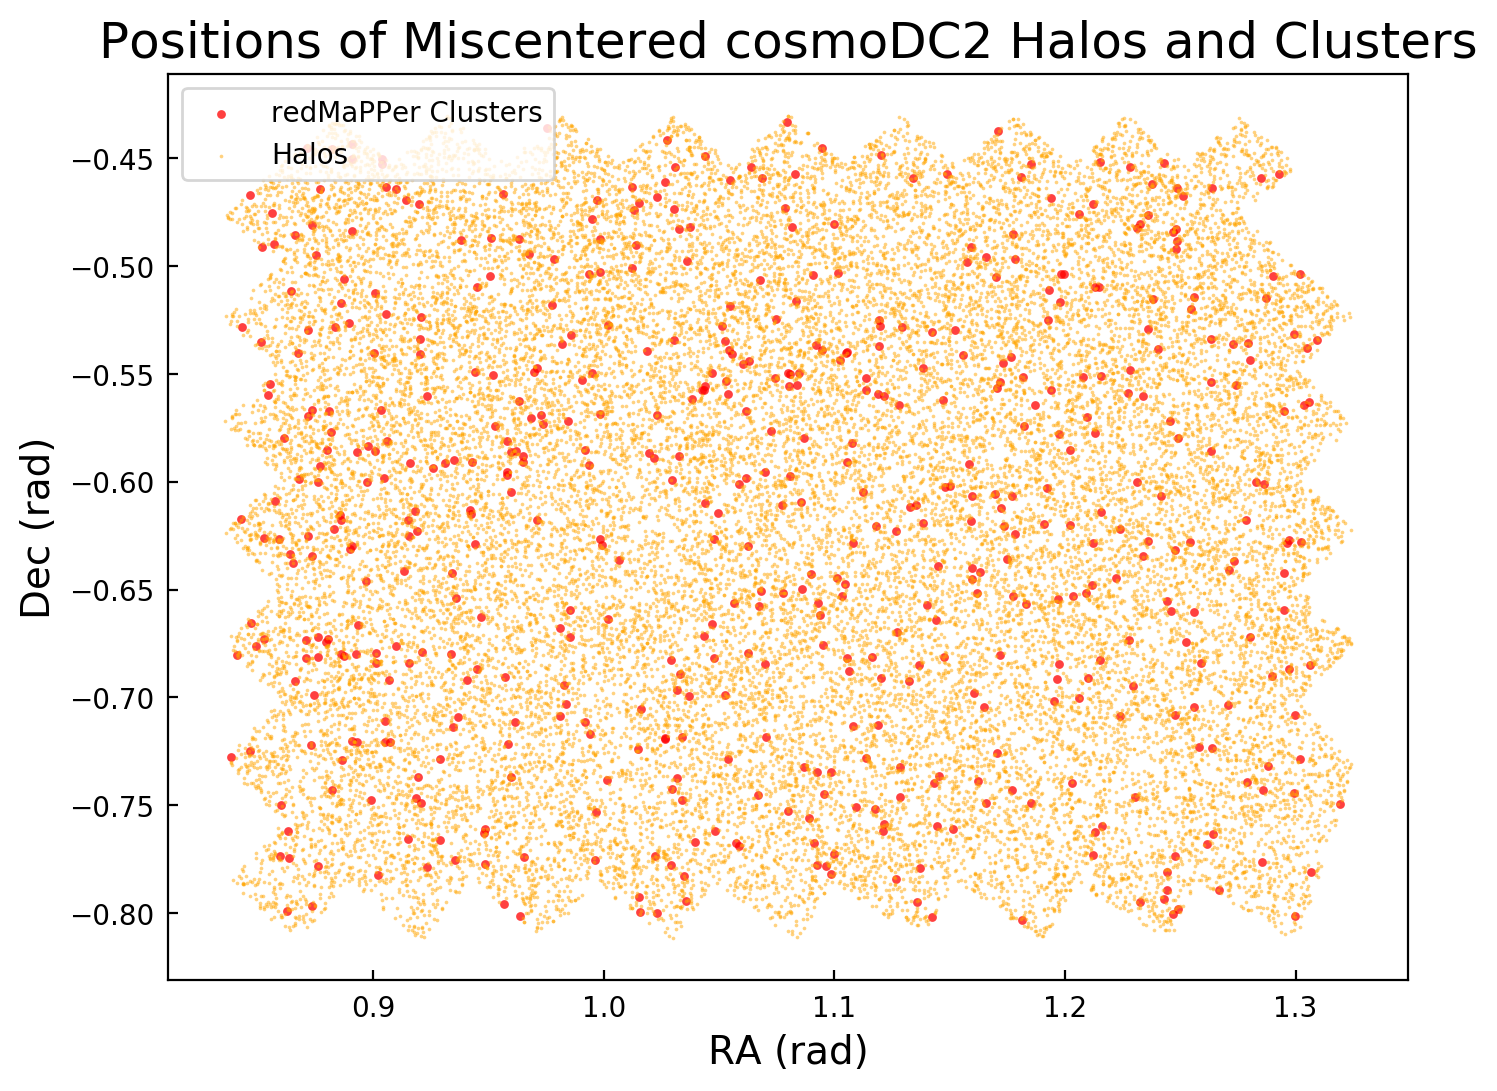

In [25]:
# halos still match clusters
plt.figure(figsize=(8,6))
plt.scatter(mredM_ra, mredM_dec, c='r', s=10, alpha=0.75, marker='o',linewidth=0.0, label='redMaPPer Clusters')
plt.scatter(mhalos_ra[::15], mhalos_dec[::15], c='orange', marker='.', s=7, linewidth=0.0, alpha=0.5, label='Halos')

plt.xlabel('RA (rad)', fontsize=14); plt.ylabel('Dec (rad)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of Miscentered cosmoDC2 Halos and Clusters', fontsize=18)
#plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

#### Halo-Cluster Algorithm

We'll set limits on redshift difference and comoving distance of $\Delta{z} < 0.05$ and $D_{com} < 2$ Mpc h$^{-1}$, respectively.

In [64]:
z_lim = 0.05 # play around with 0.05, 0.1, 0.15
comvd_lim = 2 # play around with 1, 1.5, 2

In [65]:
# sort indices for mhalos_mass
mhalos_sorted = np.asarray(sorted(range(len(mhalos_mass)),key=lambda x:mhalos_mass[x],reverse=True))
print("Number of halos:", mhalos_sorted.shape[0])

Number of halos: 468215


In [66]:
# go down list of halos from most to least massive and find potential cluster matches

redM_match_ind = np.array([])
#redM_match_ind = []              # indices of (potentially) matched clusters
redM_uniq_ind = np.array([])
#redM_uniq_ind = []               # unique indices to select uniquely matched clusters

dcmv_match_halos = np.array([])
#dcmv_match_halos = []                # comoving distance between matched cluster-halo pairs

for i in tqdm(range(mhalos_sorted.shape[0])):
    
    # track progress, this is a long one
    time.sleep(1e-20)

    # parameters for the single halo
    cur_halo_ra = mhalos_ra[mhalos_sorted[i]]; 
    cur_halo_dec = mhalos_dec[mhalos_sorted[i]]
    cur_halo_z = mhalos_z[mhalos_sorted[i]]
    cur_halo_comvd = mhalos_comvd[mhalos_sorted[i]]
    
    # assume clusters that fall in this redshift range have the same redshift as the halo
    # find distance to the halo according to this assumption, and find ones local to the halo
    z_lim_redM_ind = np.asarray(np.where(np.abs(cur_halo_z - mredM_z) < z_lim)[0])

    # filter clusters in redshift proximity region
    mredM_ra_zfilt = mredM_ra[z_lim_redM_ind]
    mredM_dec_zfilt = mredM_dec[z_lim_redM_ind]

    
    # use spherical law of cosines to find angle difference from RA, Dec
    d_lmda = mredM_ra_zfilt - cur_halo_ra
    d_Sigma = np.arccos(np.sin(mredM_dec_zfilt)*np.sin(cur_halo_dec)+\
                        np.cos(mredM_dec_zfilt)*np.cos(cur_halo_dec)*np.cos(d_lmda))
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * cur_halo_comvd**2. * (1. - np.cos(d_Sigma)))
    
    # find eligible local clusters based on proximity, and remove repeat clusters already taken by
    # higher mass halos
    loc_redM_ind = z_lim_redM_ind[np.where(dist_cmv < comvd_lim)]
    loc_redM_ind = np.setdiff1d(loc_redM_ind, redM_uniq_ind) # remove clusters already taken by 
                                                            # higher mass halos
    # if there are local clusters present, find the richest
    if np.size(loc_redM_ind) > 0:
        cur_redM_match_ind = loc_redM_ind[np.argmax(mredM_lambda[loc_redM_ind])]
        
        #redM_uniq_ind = np.append(redM_uniq_ind, redM_match_ind)
        
        redM_match_ind_append = redM_match_ind[redM_match_ind != -1]
        if np.size(redM_match_ind_append) > 0:
            append_ind = redM_match_ind_append[-1]
            #print(i, halos_match_ind_append.shape[0])
        else:
            append_ind = redM_match_ind_append.copy()
        
        redM_uniq_ind = np.append(redM_uniq_ind, append_ind)
        
        # current distance to matched halo
        cur_dcmv_match = dist_cmv[np.where(z_lim_redM_ind == cur_redM_match_ind)][0]
    
    else:
        cur_redM_match_ind = -1         # -1 for no match
        cur_dcmv_match = -1
        
    # add index and distance to respective arrays
    redM_match_ind = np.concatenate((redM_match_ind, [cur_redM_match_ind]))
    dcmv_match_halos = np.concatenate((dcmv_match_halos, [cur_dcmv_match]))
        
    if i%1e5 == 0:
        print("Matching halo number ", i)
        #print("Number of clusters in redshift bin: ", np.shape(z_lim_redM_ind))
        #print("Number of local clusters in distance range: ", np.shape(loc_redM_ind))
        print("Number of clusters matched to halos: {}\n".format(np.shape(np.where(redM_match_ind>-1))[1]))

  0%|          | 1068/468215 [00:00<01:27, 5347.80it/s]

Matching halo number  0
Number of clusters matched to halos: 1



 21%|██▏       | 100386/468215 [00:32<02:40, 2295.88it/s]

Matching halo number  100000
Number of clusters matched to halos: 566



 43%|████▎     | 200186/468215 [01:28<03:01, 1479.56it/s]

Matching halo number  200000
Number of clusters matched to halos: 567



 64%|██████▍   | 300171/468215 [02:50<02:38, 1058.34it/s]

Matching halo number  300000
Number of clusters matched to halos: 567



 85%|████████▌ | 400157/468215 [04:39<01:23, 815.37it/s] 

Matching halo number  400000
Number of clusters matched to halos: 567



100%|██████████| 468215/468215 [06:08<00:00, 1270.50it/s]


In [67]:
# how many clusters got matched to halos?
halos_match_ind_hcl = np.where(redM_match_ind != -1)
print("Number of clusters matched to halos: {}".format(np.shape(halos_match_ind_hcl)[1]))

Number of clusters matched to halos: 567


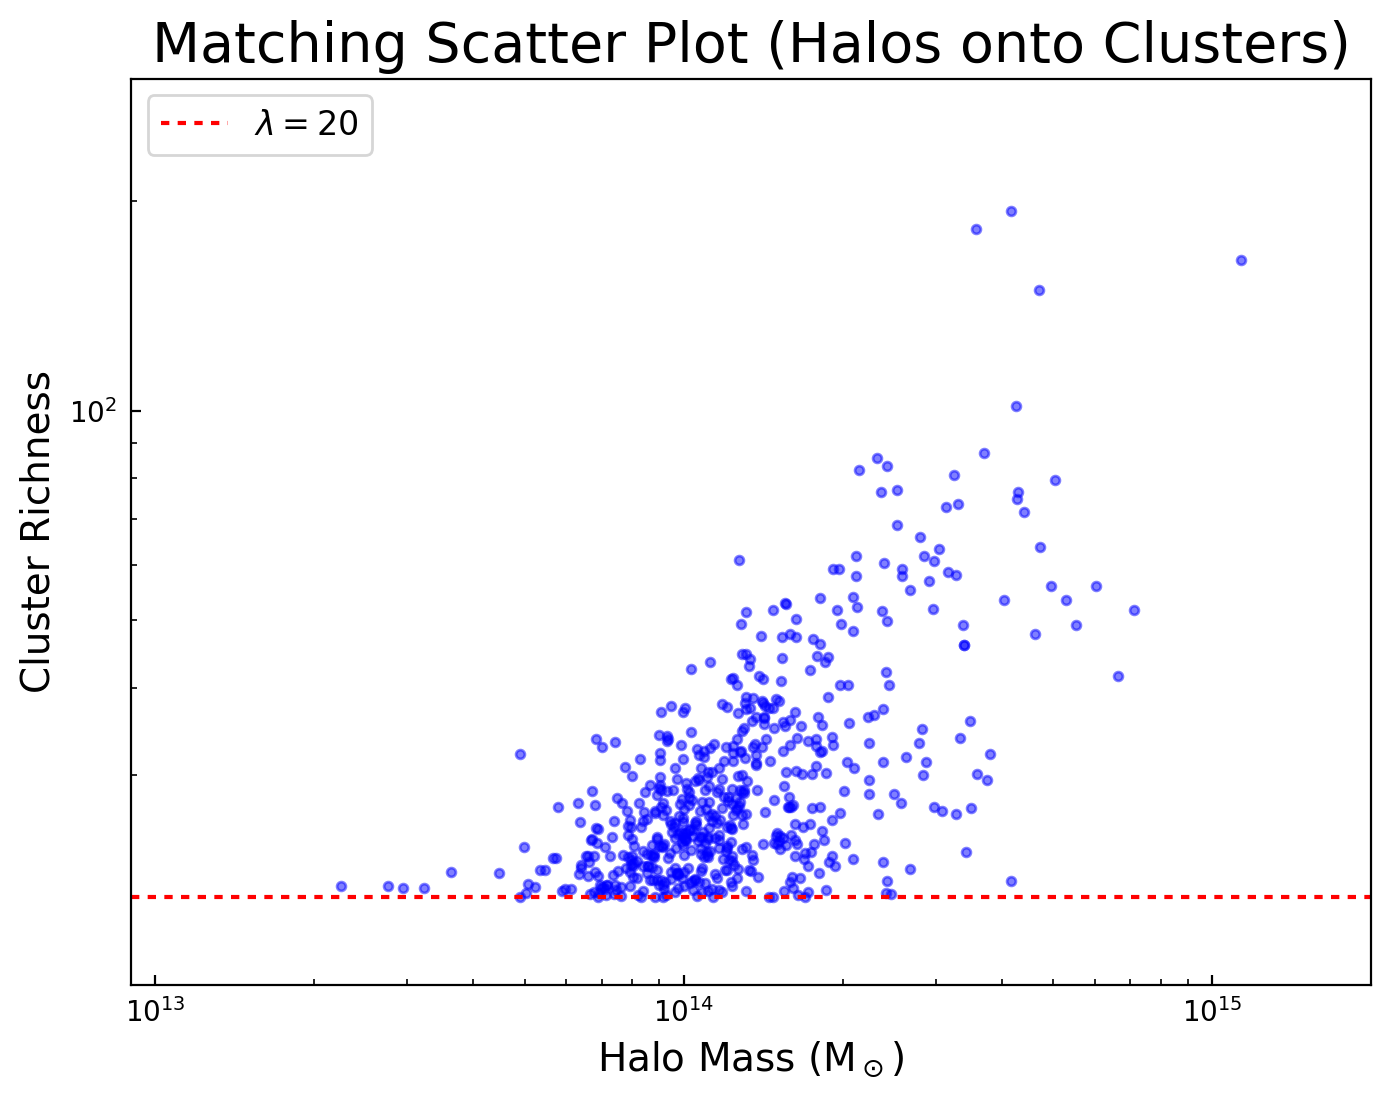

In [69]:
### ADD DISTANCE STUFF WHEN IT'S READY

# sample of mass-richness using matched clusters
dcmv_match_hcl = dcmv_match_halos[halos_match_ind_hcl]
halos_mass_match_hcl = mhalos_mass[mhalos_sorted[halos_match_ind_hcl]]
redM_lambda_match_hcl = mredM_lambda[np.asarray(redM_match_ind[halos_match_ind_hcl],dtype=int)]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_mass_match_hcl, redM_lambda_match_hcl, c='b', alpha=0.5,s=10)
plt.plot(x,y,':r', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Matching Scatter Plot (Halos onto Clusters)', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Cluster-Halo Algorithm

We're using the same constraints of $\Delta{z} < 0.05$ and $D_{com} < 2$ Mpc h$^{-1}$.

In [70]:
# sort indices for mhalos_mass
mredM_sorted = np.asarray(sorted(range(len(mredM_lambda)),key=lambda x:mredM_lambda[x],reverse=True))
print("Number of clusters:", mredM_sorted.shape[0])

Number of clusters: 562


In [71]:
# go down list of clusters from most to least rich and find potential halo matches

### CHANGE TO LISTS INSTEAD OF ARRAYS IF IT WORKS BETTER ABOVE

halos_match_ind = np.array([])      # indices of (potentially) matched halos
halos_uniq_ind = np.array([])       # unique indices to select uniquely matched halos

dcmv_match_redM = np.array([])      # comoving distance between matched cluster-halo pairs

for i in tqdm(range(mredM_sorted.shape[0])):

    # track progress
    time.sleep(1e-20)
    
    # parameters for the single halo
    cur_redM_ra = mredM_ra[mredM_sorted[i]]; 
    cur_redM_dec = mredM_dec[mredM_sorted[i]]
    cur_redM_z = mredM_z[mredM_sorted[i]]
    cur_redM_comvd = mredM_comvd[mredM_sorted[i]]
    
    # assume halos that fall in this redshift range have the same redshift as the cluster
    # find distance to the cluster according to this assumption, and find ones local to the cluster
    z_lim_halo_ind = np.asarray(np.where(np.abs(cur_redM_z - mhalos_z) < z_lim)[0])

    # filter halos in redshift proximity region
    mhalo_ra_zfilt = mhalos_ra[z_lim_halo_ind]
    mhalo_dec_zfilt = mhalos_dec[z_lim_halo_ind]

    
    # use spherical law of cosines to find angle difference from RA, Dec
    d_lmda = mhalo_ra_zfilt - cur_redM_ra
    d_Sigma = np.arccos(np.sin(mhalo_dec_zfilt)*np.sin(cur_redM_dec)+\
                        np.cos(mhalo_dec_zfilt)*np.cos(cur_redM_dec)*np.cos(d_lmda))
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * cur_redM_comvd**2. * (1. - np.cos(d_Sigma)))
    
    # find eligible local clusters based on proximity, and remove repeat clusters already taken by
    # higher mass halos
    loc_halo_ind = z_lim_halo_ind[np.where(dist_cmv < comvd_lim)]
    loc_halo_ind = np.setdiff1d(loc_halo_ind, halos_uniq_ind) # remove halos already taken by 
                                                              # richer clusters
    # if there are local halos present, find the most massive
    if np.size(loc_halo_ind) > 0:
        cur_halo_match_ind = loc_halo_ind[np.argmax(mhalos_mass[loc_halo_ind])]
        
        #halos_uniq_ind = np.append(halos_uniq_ind, halos_match_ind)
        
        halos_match_ind_append = halos_match_ind[halos_match_ind != -1]
        if np.size(halos_match_ind_append) > 0:
            append_ind = halos_match_ind_append[-1]
            #print(i, halos_match_ind_append.shape[0])
        else:
            append_ind = halos_match_ind_append.copy()
        
        halos_uniq_ind = np.append(halos_uniq_ind, append_ind)
        
        # current distance to matched halo
        cur_dcmv_match = dist_cmv[np.where(z_lim_halo_ind == cur_halo_match_ind)][0]
    
    else:
        cur_halo_match_ind = -1         # -1 for no match
        cur_dcmv_match = -1
        
    halos_match_ind = np.concatenate((halos_match_ind, [cur_halo_match_ind]))
    dcmv_match_redM = np.concatenate((dcmv_match_redM, [cur_dcmv_match]))
    
    if i%1e3 == 0:
        print("Matching cluster number ", i)
        #print("Number of clusters in redshift bin: ", np.shape(z_lim_redM_ind))
        #print("Number of local clusters in distance range: ", np.shape(loc_redM_ind))
        print("Number of halos matched to clusters: {}\n".format(np.shape(np.where(halos_match_ind>-1))[1]))
        
        #print(halos_match_ind[halos_match_ind != -1])
        
    if i == 14056: 
        print('we got here', i)
        break
        
        
print("Done!")

  1%|          | 7/562 [00:00<00:08, 62.69it/s]

Matching cluster number  0
Number of halos matched to clusters: 1



100%|██████████| 562/562 [00:09<00:00, 62.22it/s]

Done!


In [72]:
# how many halos got matched to clusters?
print("Number of clusters matched to halos: {}\n".format(np.shape(np.where(halos_match_ind>-1))[1]))

Number of clusters matched to halos: 560



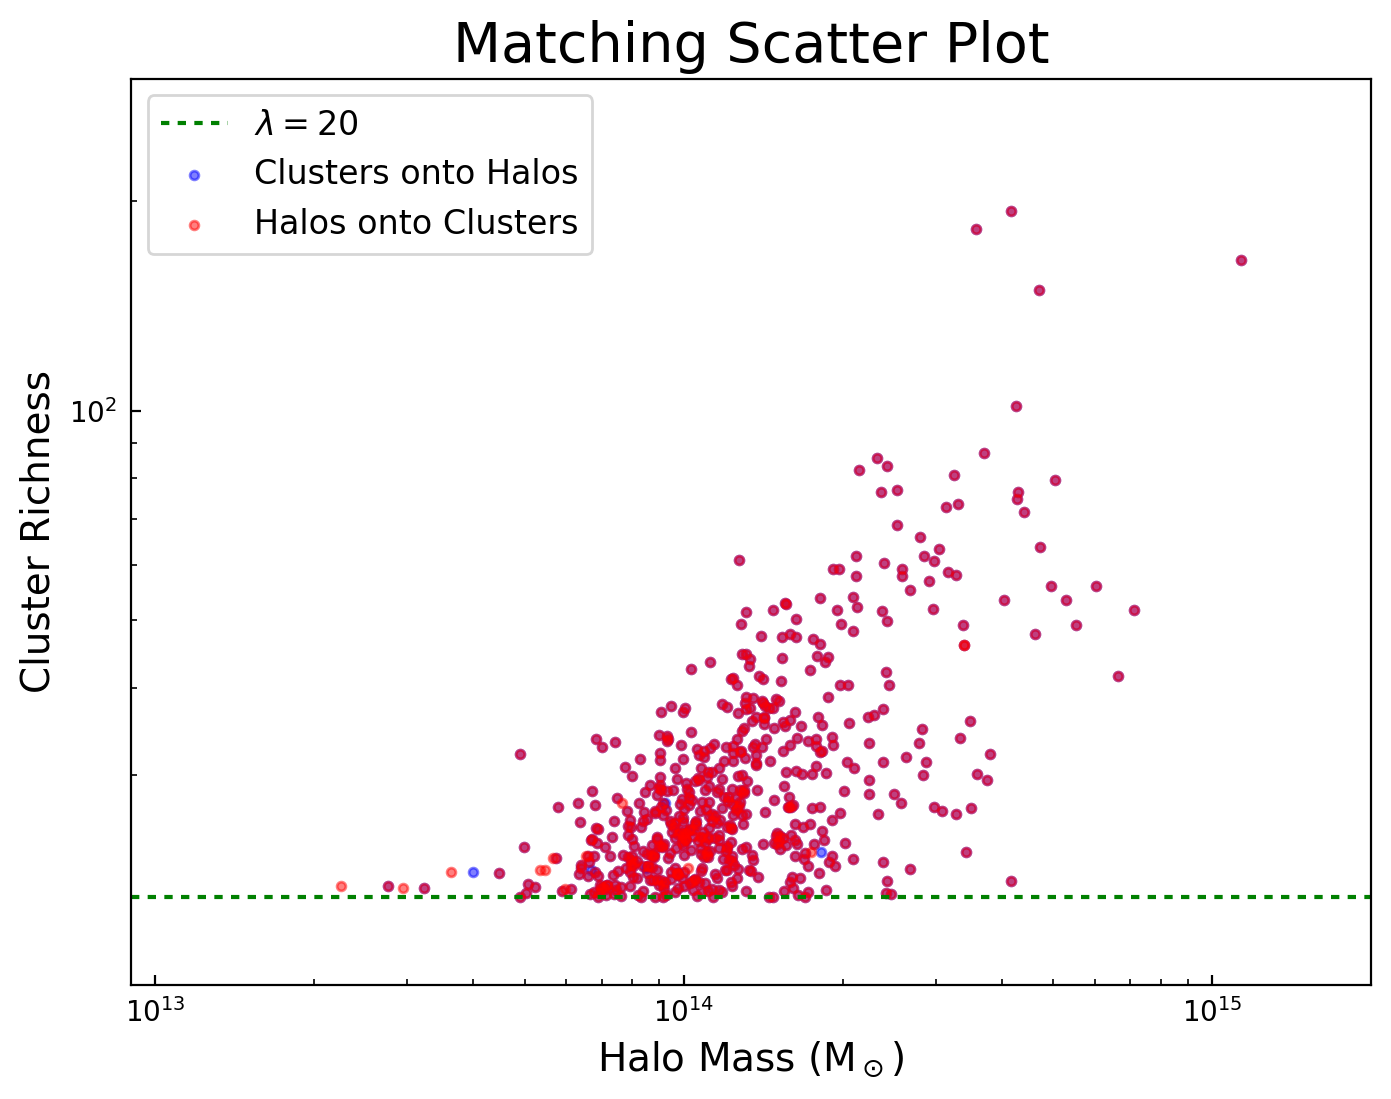

In [73]:
# sample of mass-richness using matched halos

redM_match_ind_clh = np.where(halos_match_ind != -1)

dcmv_match_clh = dcmv_match_redM[redM_match_ind_clh]
redM_lambda_match_clh = mredM_lambda[mredM_sorted[redM_match_ind_clh]]
halos_mass_match_clh = mhalos_mass[np.asarray(halos_match_ind[redM_match_ind_clh],dtype=int)]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_mass_match_clh, redM_lambda_match_clh, c='b', alpha=0.5,s=10, label='Clusters onto Halos')
plt.scatter(halos_mass_match_hcl, redM_lambda_match_hcl, c='r', alpha=0.5,s=10, label='Halos onto Clusters')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Matching Scatter Plot', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Debugging

In [74]:
# check that in redM_match_ind, the clusters matched to halos are physically adjacent, and check
# for redshift

# clusters
print("Checking redM_match_ind...")
redM_match_ind_full = np.where(redM_match_ind != -1)
redM_zfilt = np.asarray(redM_match_ind[redM_match_ind_full], dtype=int)
mhalos_z_sorted = np.asarray(mhalos_z[mhalos_sorted])
redM_zdiff = mhalos_z_sorted[redM_match_ind_full] - mredM_z[redM_zfilt]

redM_z_excess = [x for i, x in enumerate(redM_zdiff) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess), "\n")

# repeat for halos and halos_match_ind
print("Checking halos_match_ind...")
halos_match_ind_full = np.where(halos_match_ind != -1)
halos_zfilt = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
mredM_z_sorted = np.asarray(mredM_z[mredM_sorted])
halos_zdiff = mredM_z_sorted[halos_match_ind_full] - mhalos_z[halos_zfilt]

halos_z_excess = [x for i, x in enumerate(halos_zdiff) if x > z_lim]
print("Redshift differences outside of specified range:", len(halos_z_excess), "\n")

# see if unsorting algorithm works as specified. redM_match_ind and halos_match_ind have indices
# sorted by halo mass and cluster rank. again check for redshift

# find unsorted halos to match to clusters
print("Checking for redM_match_ind unsorted matching...")
a = np.asarray(redM_match_ind[redM_match_ind_full], dtype=int)
b = np.asarray(mhalos_sorted[redM_match_ind_full], dtype=int)
redM_zdiff2 = mhalos_z[b] - mredM_z[a]
redM_z_excess2 = [x for i, x in enumerate(redM_zdiff2) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess2), '\n')

# find unsorted clusters to match to halos
print("Checking for halos_match_ind unsorted matching...")
c = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
d = np.asarray(mredM_sorted[halos_match_ind_full], dtype=int)
halos_zdiff2 = mredM_z[d] - mhalos_z[c]
halos_z_excess2 = [x for i, x in enumerate(halos_zdiff2) if x > z_lim]
print("Redshift differences outside of specified range:", len(halos_z_excess2), '\n')

print("Unsort full arrays and then check for match.")
redM_match_ind_unsorted = np.array(redM_match_ind, dtype=int)

trim_mhalos_sorted = []
idx = 0
while(idx < len(redM_match_ind_unsorted)):
    val = mhalos_sorted[idx]
    trim_mhalos_sorted.append(val)
    idx += 1
trim_mhalos_sorted = np.asarray(trim_mhalos_sorted)
print(np.max(trim_mhalos_sorted))

redM_match_ind_unsorted[trim_mhalos_sorted] = redM_match_ind
#redM_match_ind_unsorted[mhalos_sorted] = redM_match_ind

uniq_match_ind = np.where(redM_match_ind_unsorted != -1)  # referring to unsorted halos
uniq_match_val = redM_match_ind_unsorted[uniq_match_ind]  # matched clusters to unsorted halos
redM_zdiff3 = mhalos_z[uniq_match_ind] - mredM_z[uniq_match_val]
redM_z_excess3 = [x for i, x in enumerate(redM_zdiff3) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess3))

print("Checking that uniq_match_ind are the same halos (albeit in the wrong order)...")
e = mhalos_z[uniq_match_ind]
f = mhalos_z_sorted[redM_match_ind_full]
g = np.setdiff1d(e, f)
print("Different halos in sorted and unsorted (order doesn't matter):", len(g))

Checking redM_match_ind...
Redshift differences outside of specified range: 0 

Checking halos_match_ind...
Redshift differences outside of specified range: 0 

Checking for redM_match_ind unsorted matching...
Redshift differences outside of specified range: 0 

Checking for halos_match_ind unsorted matching...
Redshift differences outside of specified range: 0 

Unsort full arrays and then check for match.
468214
Redshift differences outside of specified range: 0
Checking that uniq_match_ind are the same halos (albeit in the wrong order)...
Different halos in sorted and unsorted (order doesn't matter): 0


### Uniqueness Algorithm

If a cluster matches onto a halo, then that halo matches onto that cluster.

In [75]:
# clusters
redM_match_ind_unsorted = np.array(redM_match_ind, dtype=int)
print(redM_match_ind_unsorted[0])
redM_match_ind_unsorted[mhalos_sorted] = redM_match_ind
print(redM_match_ind_unsorted[mhalos_sorted[0]])

# halos
halos_match_ind_unsorted = np.array(halos_match_ind, dtype=int)
halos_match_ind_unsorted[mredM_sorted] = halos_match_ind

uniq_match_ind = np.where(redM_match_ind_unsorted != -1)  # unsorted halos
uniq_match_val = redM_match_ind_unsorted[uniq_match_ind]  # matched clusters to unsorted halos
nonuniq_match_val = [x for x in range(len(halos_match_ind_unsorted)) if x not in uniq_match_val]
# assign all non_uniq halos to -1

uniq_match_bool = halos_match_ind_unsorted[uniq_match_val] == uniq_match_ind
uniq_match_bool = uniq_match_bool[0]
print("Number of one way clusters matched to halos:", np.shape(halos_match_ind_unsorted[uniq_match_val]))
print("Number of unique matches:", np.shape(np.where(uniq_match_bool == True)))

a = np.array(halos_match_ind_unsorted[uniq_match_val])
np.place(a, uniq_match_bool==False, -1)
halos_match_ind_unsorted[uniq_match_val] = a
halos_match_ind_unsorted[nonuniq_match_val] = -1
halos_uniq_ind_unsorted = np.copy(halos_match_ind_unsorted)

# final cuts
mredM_cut = np.where(halos_uniq_ind_unsorted != -1)
mhalos_cut = halos_uniq_ind_unsorted[mredM_cut]

print("Number of unique matches after cutting out non-unique matches:", np.shape(mredM_cut))

550
550
Number of one way clusters matched to halos: (567,)
Number of unique matches: (1, 554)
Number of unique matches after cutting out non-unique matches: (1, 551)


In [76]:
redM_match_ind_copy = np.copy(redM_match_ind).astype(int)
halos_match_ind_copy = np.copy(halos_match_ind).astype(int)

'''uniq_match_ind_2 = np.where(redM_match_ind_copy != -1)  # unsorted halos
uniq_match_val_2 = redM_match_ind_copy[uniq_match_ind_2]  # matched clusters to unsorted halos
nonuniq_match_val_2 = [x for x in range(len(halos_match_ind_copy)) if x not in uniq_match_val_2]
# assign all non_uniq halos to -1

uniq_match_bool_2 = halos_match_ind_copy[uniq_match_val_2] == uniq_match_ind_2
uniq_match_bool_2 = uniq_match_bool_2[0]
print("Number of one way clusters matched to halos:", np.shape(halos_match_ind_copy[uniq_match_val_2]))
print("Number of unique matches:", np.shape(np.where(uniq_match_bool_2 == True)))

a = np.array(halos_match_ind_copy[uniq_match_val_2])
np.place(a, uniq_match_bool_2==False, -1)
halos_match_ind_copy[uniq_match_val] = a
halos_match_ind_copy[nonuniq_match_val] = -1
halos_uniq_ind_copy = np.copy(halos_match_ind_copy)

# final cuts
mredM_sorted_copy = np.where(halos_match_ind_copy != -1)
mhalos_sorted_copy = halos_match_ind_copy[mredM_sorted_copy]'''

import esutil

In [77]:
a, b = esutil.numpy_util.match(mredM_cut[0], mredM_sorted[np.where(halos_match_ind != -1)])

# get distances
dcmv_uniq_redM = dcmv_match_redM.copy()
dcmv_uniq_redM[mredM_sorted] = dcmv_match_redM
dcmv_uniq_redM = dcmv_uniq_redM[mredM_cut]

dcmv_uniq_halos = dcmv_match_halos.copy()
dcmv_uniq_halos[mhalos_sorted] = dcmv_match_halos
dcmv_uniq_halos = dcmv_uniq_halos[mhalos_cut]

# check to see if they're the same (probably above in debugging section)
# append to centered list in the Merging Data section
dcmv_big_diff = [np.abs(d1 - d2) for d1, d2 in zip(dcmv_uniq_redM, dcmv_uniq_halos) if np.abs(d1 - d2) > 1e-3]
print("Number of unequal comoving distance calculations:", len(dcmv_big_diff))
print(np.array(dcmv_big_diff).max())

# connect to localhost and run this stuff



######

# HERE IS WHERE NOTES ARE!

######

Number of unequal comoving distance calculations: 339
0.24835123653642932


### Merging Data

In [78]:
mredM_matched = np.asarray(redM_miscent[mredM_cut])
mhalos_matched = np.asarray(halos_miscent[mhalos_cut])

assert len(mredM_matched) == len(mhalos_matched)
assert len(redM_cent) == len(halos_cent)

print("Number of miscentered matched:", len(mredM_matched))
print("Number of centered matched:", len(redM_cent))

Number of miscentered matched: 551
Number of centered matched: 3751


Add a `centered_flag` to tell whether the matching is done automatically by centering or through proximity matching.

https://stackoverflow.com/questions/1201817/adding-a-field-to-a-structured-numpy-array

In [79]:
def add_field(arr, descr):
    """Return a new array that is like "a", but has additional fields.

    Arguments:
      arr    --  a structured numpy array
      descr  --  a numpy type description of the new fields

    The contents of "arr" are copied over to the appropriate fields in
    the new array, whereas the new fields are uninitialized.  The
    arguments are not modified.

    >>> sa = numpy.array([(1, 'Foo'), (2, 'Bar')], \
                         dtype=[('id', int), ('name', 'S3')])
    >>> sa.dtype.descr == numpy.dtype([('id', int), ('name', 'S3')])
    True
    >>> sb = add_field(sa, [('score', float)])
    >>> sb.dtype.descr == numpy.dtype([('id', int), ('name', 'S3'), \
                                       ('score', float)])
    True
    >>> numpy.all(sa['id'] == sb['id'])
    True
    >>> numpy.all(sa['name'] == sb['name'])
    True
    """
    if arr.dtype.fields is None:
        raise (ValueError, "'arr' must be a structured numpy array")
    b = np.empty(arr.shape, dtype=arr.dtype.descr + descr)
    for name in arr.dtype.names:
        b[name] = arr[name]
    return b

# add centered_flag
centered_flag = [('centered_flag', int)]
matching_id = [('matching_id', int)]

# for miscentered
mredM_matched = add_field(mredM_matched, centered_flag)
mredM_matched = add_field(mredM_matched, matching_id)
mredM_matched['centered_flag'] = 0

# for centered
#redM_cent = add_field(redM_cent, centered_flag)
#redM_cent = add_field(redM_cent, matching_id)
#redM_cent['centered_flag'] = 1

# for halos
mhalos_matched = add_field(mhalos_matched, matching_id)
#halos_cent = add_field(halos_cent, matching_id)

In [80]:
# merging the two
redM_matched = Table(np.append(redM_cent, mredM_matched))
halos_matched = Table(np.append(halos_cent, mhalos_matched))

# merge comoving distance arrays
dcmv_redM_matched = np.append(dcmv_sep_cent, dcmv_uniq_redM)
dcmv_halos_matched = np.append(dcmv_sep_cent, dcmv_uniq_halos)

# assign comoving distance between pairs to tables
redM_matched['dcmv_matched'] = dcmv_redM_matched
halos_matched['dcmv_matched'] = dcmv_halos_matched

# assign unique matching ID
#matching_ids = range(0, len(redM_matched))
#redM_matched['matching_id'] = matching_ids
#halos_matched['matching_id'] = matching_ids

# convert R_v from kpc to Mpc
#halos_matched['R_v'] /= 1000

print(redM_matched.dtype)
print(halos_matched.dtype)

[('mem_match_id', '<i4'), ('ra', '<f8'), ('dec', '<f8'), ('z', '<f4'), ('refmag', '<f4'), ('refmag_err', '<f4'), ('lambda', '<f4'), ('lambda_e', '<f4'), ('z_lambda', '<f4'), ('z_lambda_e', '<f4'), ('cg_spec_z', '<f4'), ('z_spec_init', '<f4'), ('z_init', '<f4'), ('r_lambda', '<f4'), ('r_mask', '<f4'), ('scaleval', '<f4'), ('maskfrac', '<f4'), ('zred', '<f4'), ('zred_e', '<f4'), ('zred_chisq', '<f4'), ('chisq', '<f4'), ('z_lambda_niter', '<i2'), ('ebv_mean', '<f4'), ('lnlamlike', '<f4'), ('lncglike', '<f4'), ('lnlike', '<f4'), ('ra_orig', '<f8'), ('dec_orig', '<f8'), ('w', '<f4'), ('dlambda_dz', '<f4'), ('dlambda_dz2', '<f4'), ('dlambdavar_dz', '<f4'), ('dlambdavar_dz2', '<f4'), ('z_lambda_raw', '<f4'), ('z_lambda_e_raw', '<f4'), ('bkg_local', '<f4'), ('lim_exptime', '<f4'), ('lim_limmag', '<f4'), ('lim_limmag_hard', '<f4'), ('lambda_c', '<f4'), ('lambda_ce', '<f4'), ('ncent_good', '<i2'), ('maskgal_index', '<i2'), ('mag', '<f4', (5,)), ('mag_err', '<f4', (5,)), ('pzbins', '<f4', (21,)),

In [81]:
#halos_matched['R_v'] *= 1000
#print(np.max(halos_matched['R_v']))

In [219]:
if 'dc2_dr6' in redM_file:
    redM_matched = Table(mredM_matched)
    halos_matched = Table(mhalos_matched)
    
    matching_ids = range(0, len(redM_matched))
    redM_matched['matching_id'] = matching_ids
    halos_matched['matching_id'] = matching_ids

In [82]:
# create two fits files out of the tables we've just created
redM_matched.write("../fits_files/rsep_cosmoDC2_v0.8.1/cosmoDC2_v0.8.1_redM_0.15_2.fits", format='fits')
halos_matched.write("../fits_files/rsep_cosmoDC2_v0.8.1/cosmoDC2_v0.8.1_halos_0.15_2.fits", format='fits')

# DONE WITH DR6
# DONE WITH v0.7.5
# DONE WITH v0.8.0
# DONE WITH v0.8.1, AND NOW WITH EVERYTHING

### Diagnostic Plots

In [55]:
def read_fits(filename):
    '''
    reads and returns data from a FITS file
    '''
    hdu = fits.open(filename)
    data = Table(hdu[1].data)   # second index of the hdu corresponds to the data in these table files
    hdu.close()
    
    return data

redM_matched = read_fits('../fits_files/dr6_dc2_matched_redM.fits')
halos_matched = read_fits('../fits_files/dr6_dc2_matched_halos.fits')

We'll need the metric $R_{\rm sep} / R_\lambda$, where $R_{\rm sep}$ is the halo-cluster separation distance and $R_\lambda$ is an estimate of cluster radius based on cluster richness:

$R_{\lambda} = 1$ $\rm Mpc$ $\rm h^{-1}$ $(\frac{\lambda}  {100})^{0.2}$,

where $\lambda$ is the richness of the cluster. This formula is from [Rykoff, *et al*. (2014)](https://arxiv.org/pdf/1303.3562.pdf).

**Note:** We only need to calculate this for my redMaPPer v0.7.5 files. The v0.8.1 files (which came from global/) already have it.

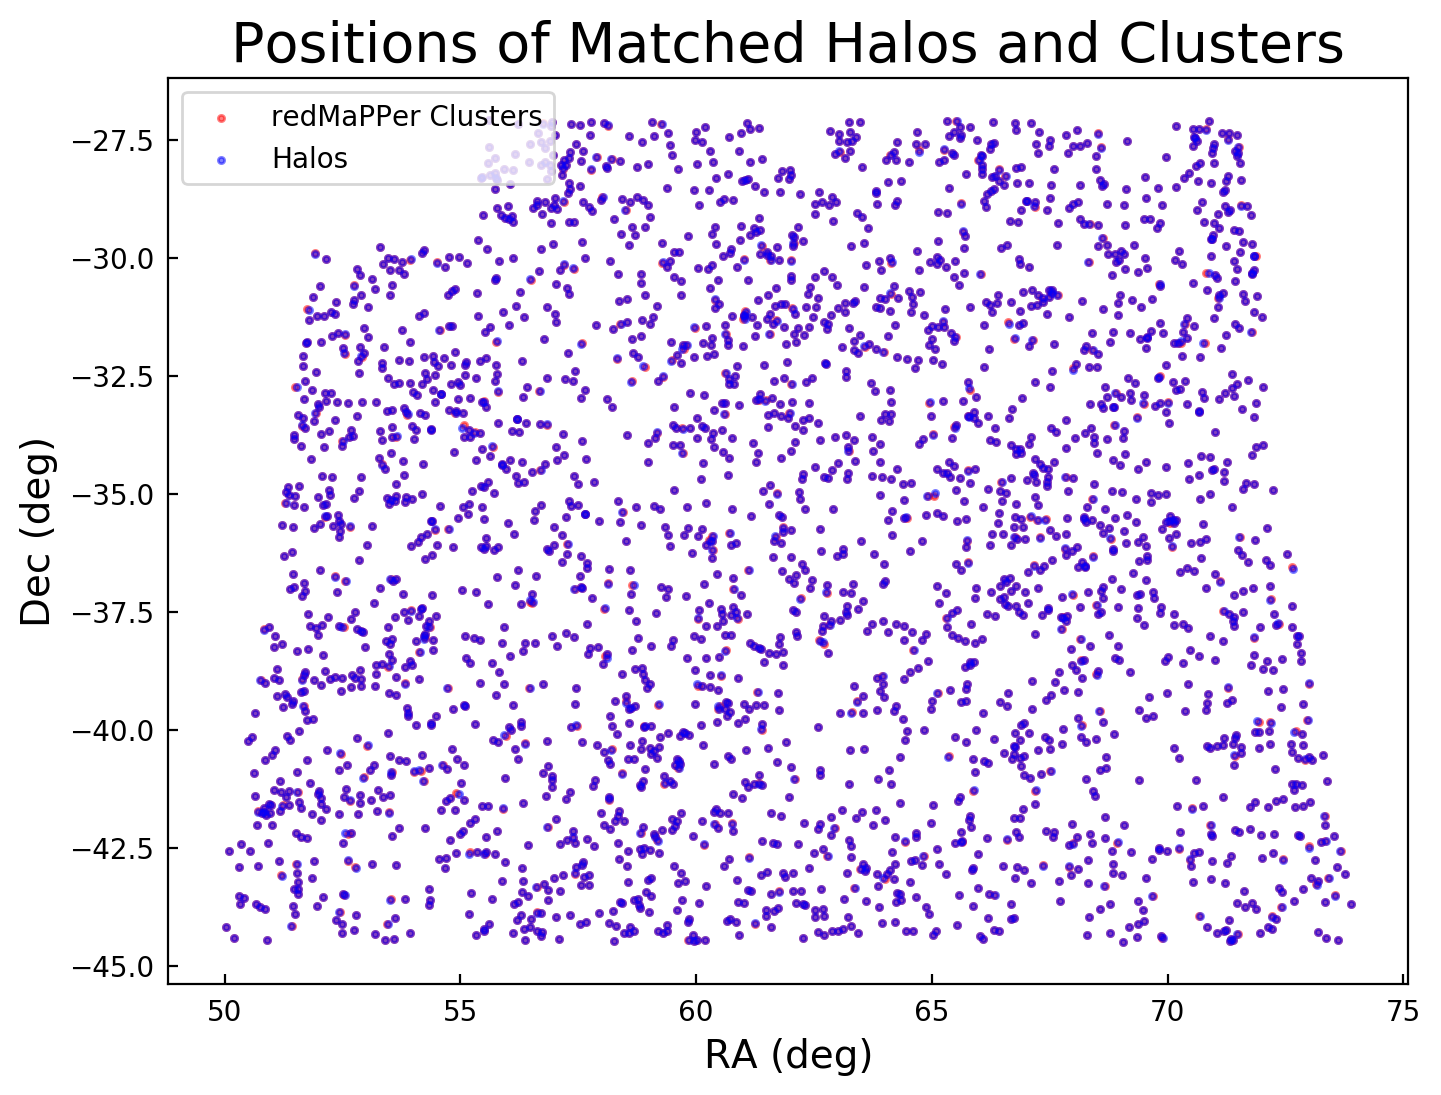

In [56]:
# Scatter plot of matched clusters and halos

plt.figure(figsize=(8,6))
plt.scatter(redM_matched['ra'], redM_matched['dec'], c='r', s=5, alpha=0.5, label='redMaPPer Clusters')
plt.scatter(halos_matched['ra'], halos_matched['dec'], c='b', s=5, alpha=0.5, label='Halos')

plt.xlabel('RA (deg)', fontsize=14); plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of Matched Halos and Clusters', fontsize=20)
#plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

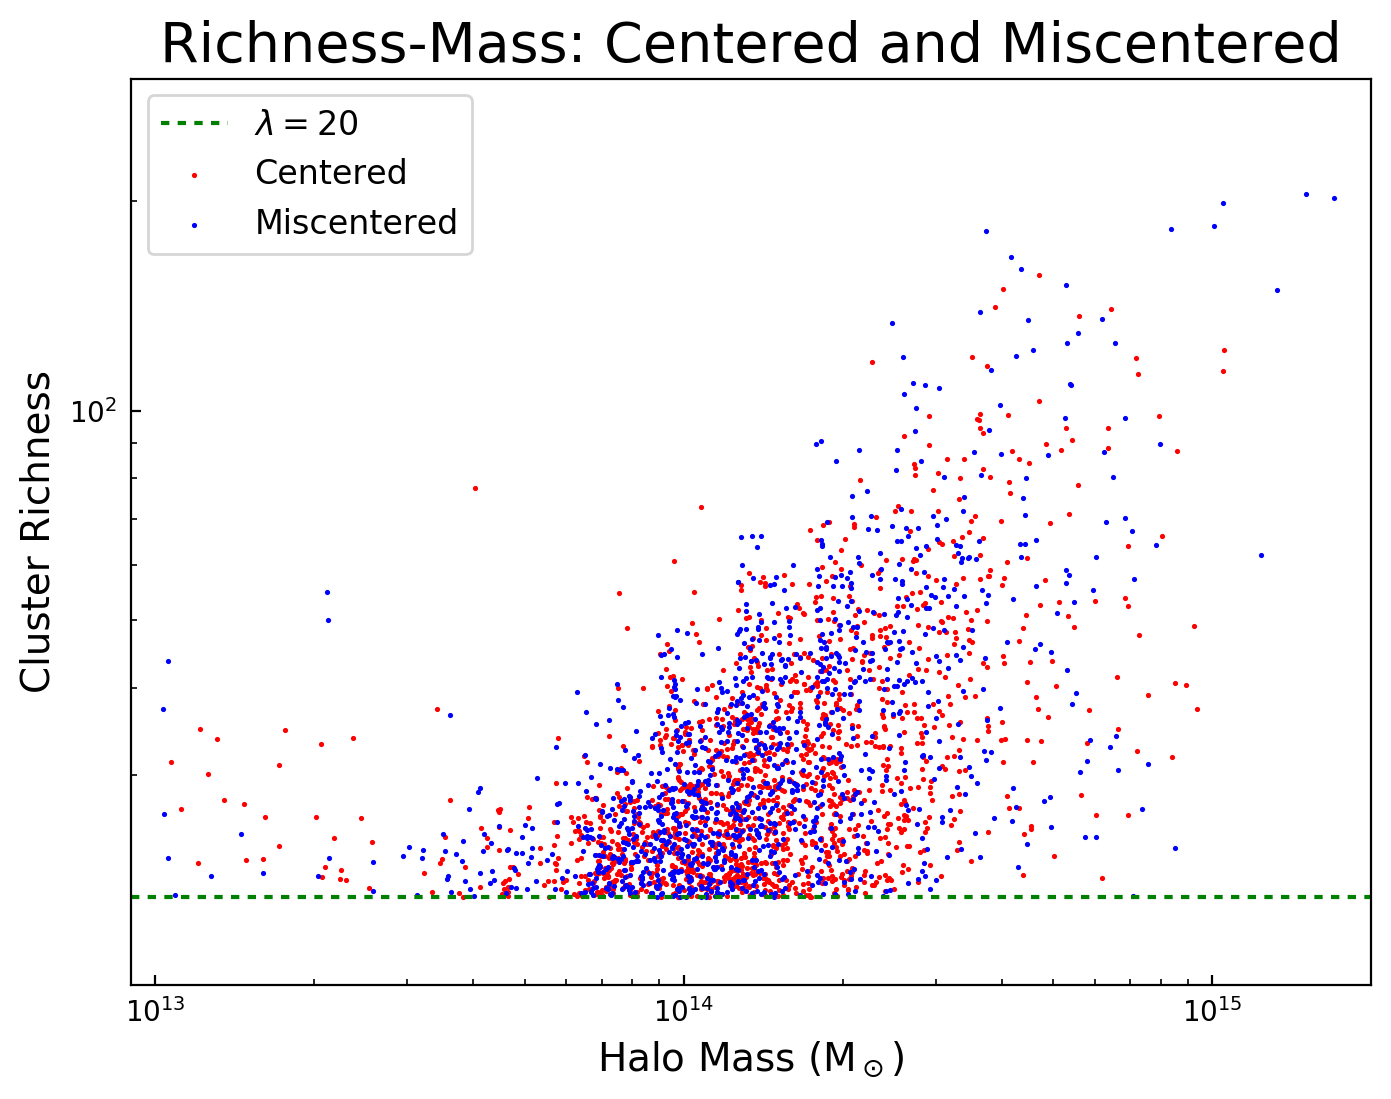

In [57]:
# richness-mass, comparing centered and miscentered

centered = np.where(redM_matched['centered_flag'] == 1)
miscentered = np.where(redM_matched['centered_flag'] == 0)

halos_cent = halos_matched[centered]
halos_miscent = halos_matched[miscentered]
redM_cent = redM_matched[centered]
redM_miscent = redM_matched[miscentered]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], redM_cent['lambda'], s=0.75, c='r', label='Centered')
plt.scatter(halos_miscent['halo_mass'], redM_miscent['lambda'], s=0.75, c='b', label='Miscentered')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass: Centered and Miscentered', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [58]:
print(len(halos_cent), len(halos_cent) / (len(halos_cent) + len(halos_miscent)))
print(len(halos_miscent), len(halos_miscent) / (len(halos_cent) + len(halos_miscent)))
print(len(halos_cent) + len(halos_miscent))

1535 0.5589949016751639
1211 0.44100509832483614
2746


"plt.hist(log_mass_comb, bins=31, alpha=0.5, color='gray', label='combined', density=True)\n\nplt.hist(log_mass_cent, bins=30, histtype='step', color='blue', label='centered', density=True)\nplt.hist(log_mass_miscent, bins=28, histtype='step', color='red', label='miscentered', density=True)\n\nplt.xlabel(r'$\\log(M$ $/$ $M_\\odot)$', fontsize=14)\nplt.ylabel(r'$P(M)$', fontsize=14)\n#plt.rc('axes', labelsize=14)\n#plt.ylim(0, 60)\nplt.legend(loc='upper left', fontsize=10)\n#plt.title('Halo Mass Distribution', fontsize=20)\nplt.show()"

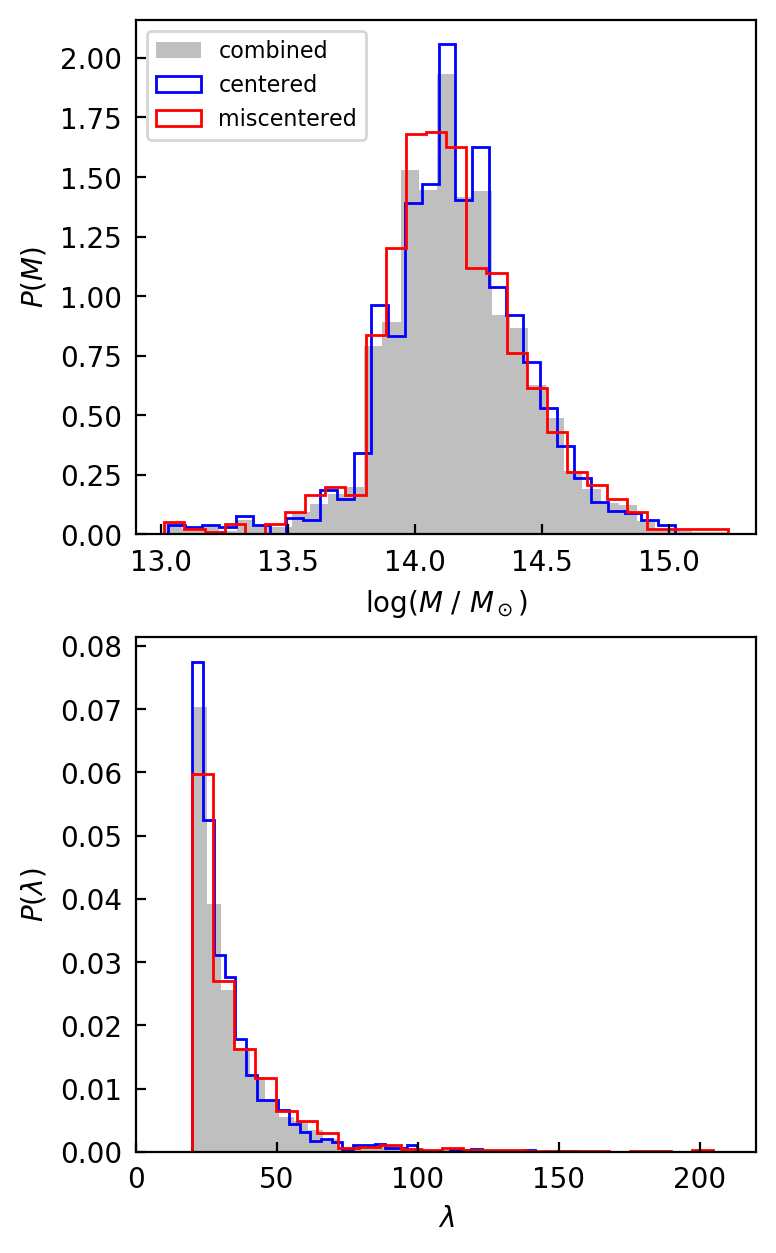

In [59]:
# histogram showing masses for centered and miscentered

log_mass_cent = np.log10(halos_cent['halo_mass'])
log_mass_miscent = np.log10(halos_miscent['halo_mass'])
log_mass_comb = np.log10(halos_matched['halo_mass'])

fig, ax = plt.subplots(2,1) 
fig.set_figheight(7.5)
fig.set_figwidth(4)

ax[0].hist(log_mass_comb, bins=31, alpha=0.5, color='gray', label='combined', density=True)
ax[0].hist(log_mass_cent, bins=30, histtype='step', color='blue', label='centered', density=True)
ax[0].hist(log_mass_miscent, bins=28, histtype='step', color='red', label='miscentered', density=True)

ax[0].set_xlabel(r'$\log(M$ $/$ $M_\odot)$', fontsize=10)
ax[0].set_ylabel(r'$P(M)$', fontsize=10)
ax[0].legend(loc='upper left', fontsize=8)

ax[1].hist(redM_matched['lambda'], bins=36, alpha=0.5, color='gray', label='combined', density=True)
ax[1].hist(redM_cent['lambda'], bins=36, histtype='step', color='blue', label='centered', density=True)
ax[1].hist(redM_miscent['lambda'], bins=25, histtype='step', color='red', label='miscentered', density=True)

ax[1].set_xlabel(r'$\lambda$', fontsize=10)
ax[1].set_ylabel(r'$P(\lambda)$', fontsize=10)

ax[1].set_xlim(0,220)
#ax[1].set_ylim(0, 0.01)

'''plt.hist(log_mass_comb, bins=31, alpha=0.5, color='gray', label='combined', density=True)

plt.hist(log_mass_cent, bins=30, histtype='step', color='blue', label='centered', density=True)
plt.hist(log_mass_miscent, bins=28, histtype='step', color='red', label='miscentered', density=True)

plt.xlabel(r'$\log(M$ $/$ $M_\odot)$', fontsize=14)
plt.ylabel(r'$P(M)$', fontsize=14)
#plt.rc('axes', labelsize=14)
#plt.ylim(0, 60)
plt.legend(loc='upper left', fontsize=10)
#plt.title('Halo Mass Distribution', fontsize=20)
plt.show()'''

In [60]:
redM_matched[centered]['dcmv_matched'][np.where(redM_matched[centered]['dcmv_matched'] != 0)].min()

3.788238158561349e-05

Text(0.5, 1.0, 'Comoving Distance Separation')

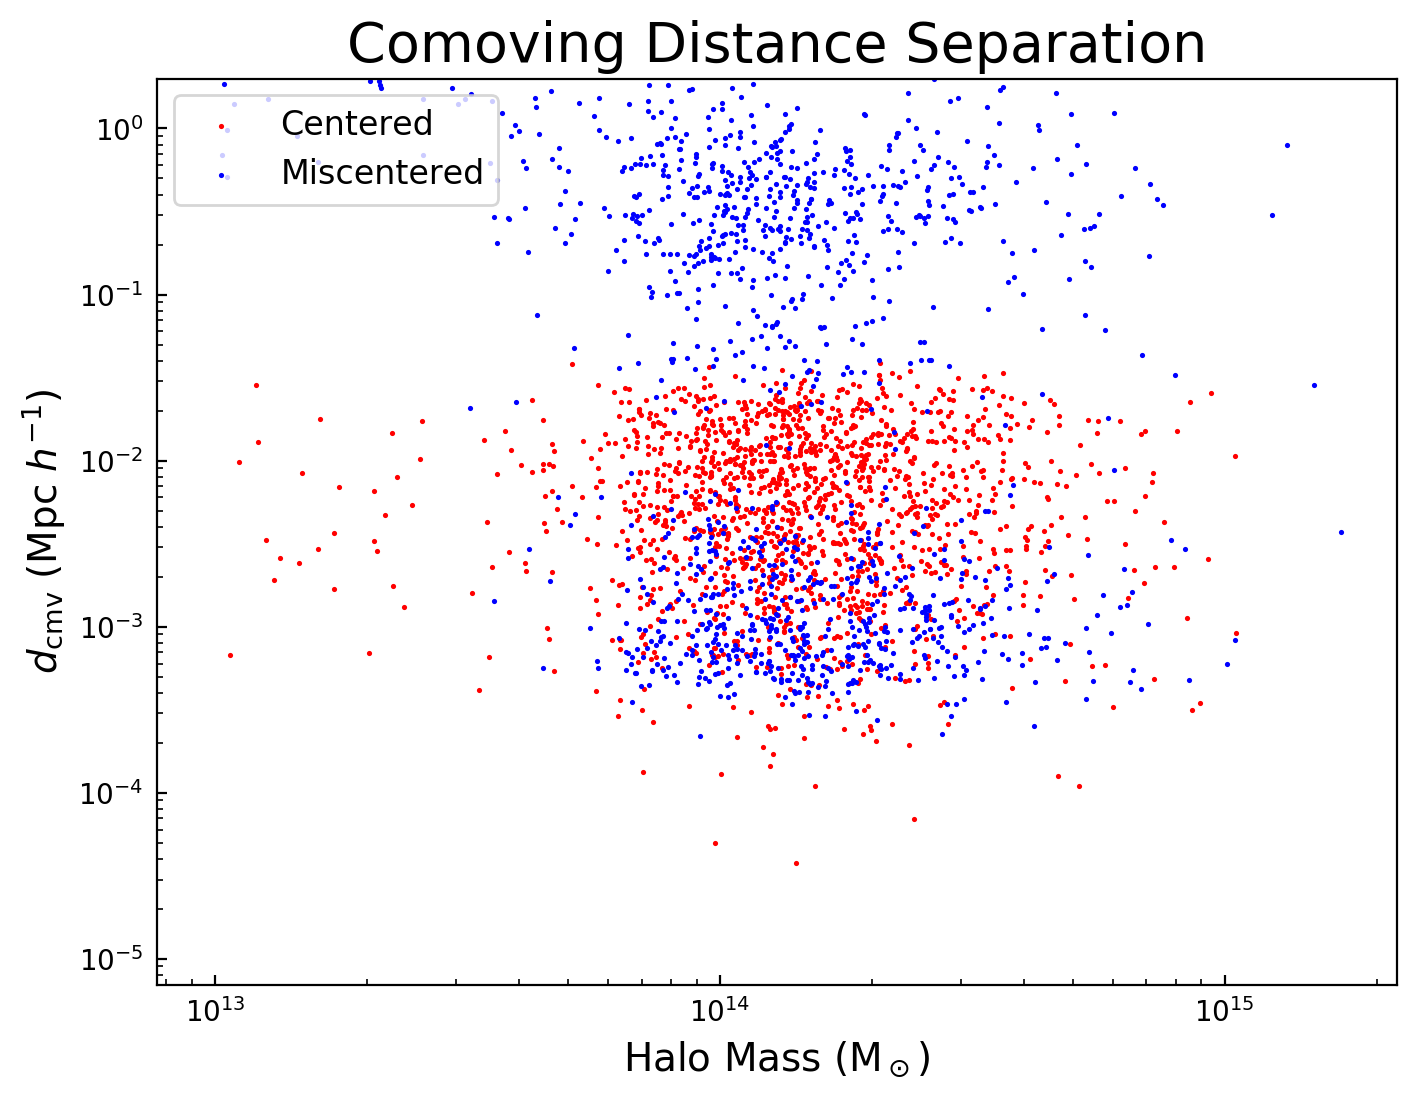

In [61]:
# comoving distance separation

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], redM_cent['dcmv_matched'], s=0.75, c='r', label='Centered')
plt.scatter(halos_miscent['halo_mass'], redM_miscent['dcmv_matched'], s=0.75, c='b', label='Miscentered')
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'$d_{\rm cmv}$ ($\rm{Mpc}$ $h^{-1}$)', fontsize=14)
plt.yscale('log')
#plt.xlim(9e12, 2e15)
plt.ylim(7e-6, 2)
plt.legend(loc='upper left', fontsize=12)
plt.title('Comoving Distance Separation', fontsize=20)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125 1.25  1.375
 1.5   1.625 1.75  1.875 2.    2.125 2.25  2.375 2.5  ]


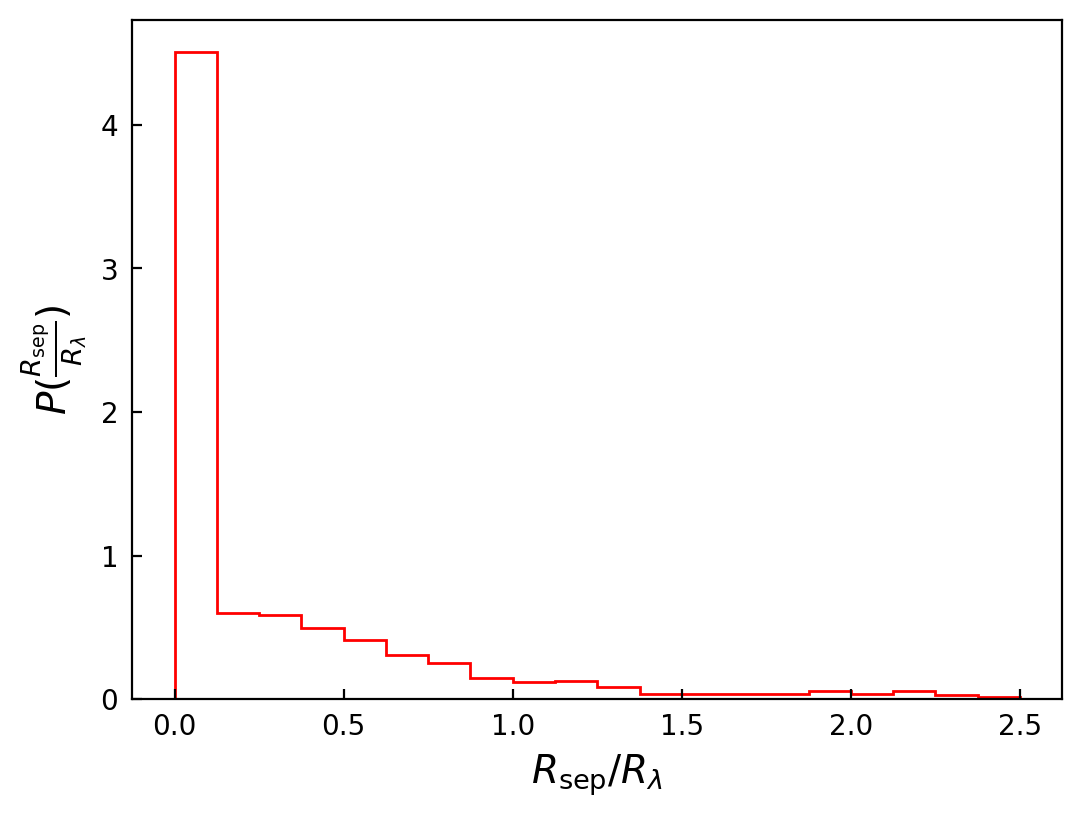

In [62]:
# histogram of comoving distance separation

rsep_cent = redM_cent['dcmv_matched']
rsep_miscent = redM_miscent['dcmv_matched']

rsep_rlambda_cent = rsep_cent / redM_cent['r_lambda']
rsep_rlambda_miscent = rsep_miscent / redM_miscent['r_lambda']

y = np.linspace(0, 10000, 5)
x = 0*y

plt.figure(figsize=(6,4.5))

bins = np.linspace(0,2.5,21)
print(bins)

plt.hist(rsep_rlambda_miscent, bins=bins
         , histtype='step', color='red', label='miscentered', density=True)

#plt.hist(rsep_cent, bins='auto', alpha=0.5, label='centered')
#plt.plot(x,y,'orange')
#plt.xscale('log')

plt.xlabel(r'$R_{\rm sep} / R_\lambda$', fontsize=14)
plt.ylabel(r'$P(\frac{R_{\rm sep}}{R_\lambda})$', fontsize=14)

#plt.xlim(0,1)

#plt.rc('axes', labelsize=14)
#plt.ylim(0, 150)
#plt.title('Halo Mass Distribution', fontsize=20)
#plt.legend(loc='upper right')
plt.show()

In [63]:
(cosmo.kpc_proper_per_arcmin(0.5).to(u.Mpc / u.arcmin) * 0.005 * 60).value

0.10967826220270892

In [64]:
def find_dist_RMsep(ra1, ra2, dec1, dec2, z2):
    
    coord1 = SkyCoord(ra1*u.deg, dec1*u.deg,  frame='icrs')
    coord2 = SkyCoord(ra2*u.deg, dec2*u.deg,  frame='icrs')
    
    sep = coord1.separation(coord2).value  #In degrees
    
    dist = (cosmo.kpc_proper_per_arcmin(z2).to(u.Mpc / u.arcmin) * sep * 60).value
    
    return dist
            
ra1 = redM_miscent['ra_cent'][:,0]
ra2 = redM_miscent['ra_cent'][:,1]

dec1 = redM_miscent['dec_cent'][:,0]
dec2 = redM_miscent['dec_cent'][:,1]

z2 = redM_miscent['zlambda_cent'][:,1]

rrmsep_miscent = find_dist_RMsep(ra1, ra2, dec1, dec2, z2)

rrmsep_rlambda_miscent = rrmsep_miscent / redM_miscent['r_lambda']

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[]

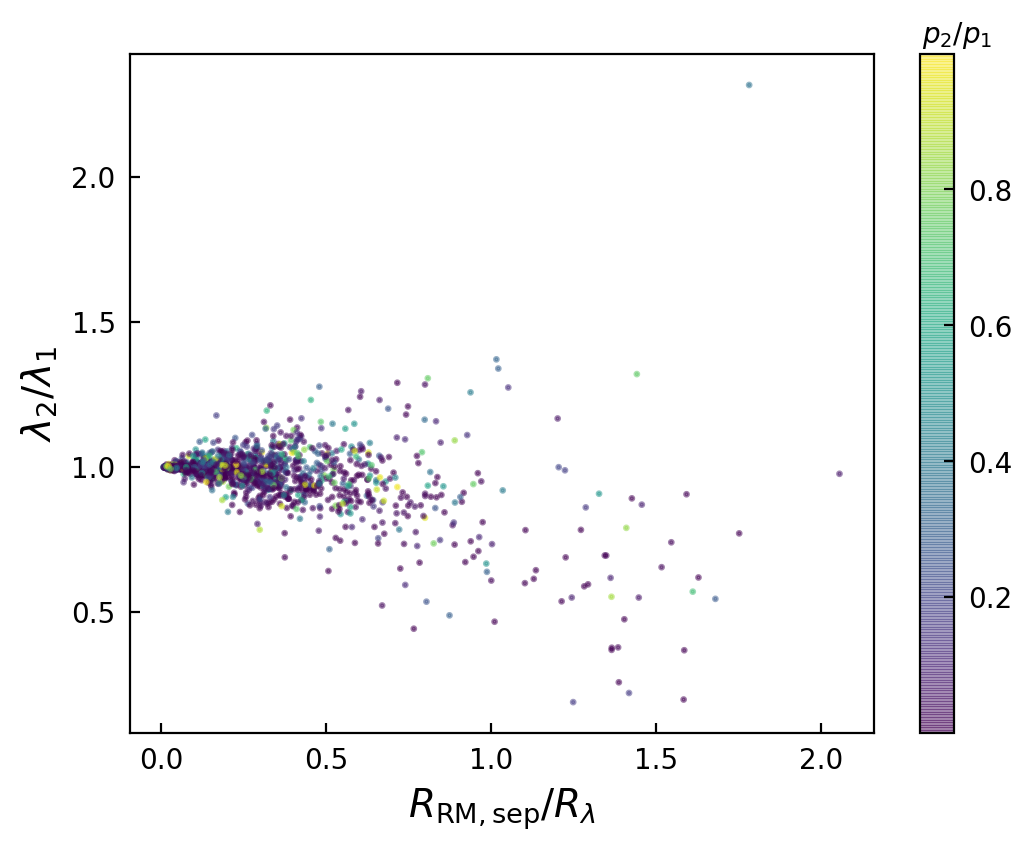

In [65]:
#redM_file_table_cent = redM_file_table_matched_sort[centered]
#redM_file_table_miscent = redM_file_table_matched_sort[miscentered]

#lambdas_miscent = redM_file_table_miscent['lambda_cent']
lambdas_miscent = redM_miscent['lambda_cent']

l2_over_l1 = lambdas_miscent[:,1] / lambdas_miscent[:,0]

#pbcg_miscent = redM_file_table_miscent['p_cen']
pbcg_miscent = redM_miscent['p_cen']

p2_over_p1 = pbcg_miscent[:,1] / pbcg_miscent[:,0]

plt.figure(figsize=(6,4.5))

#sc = plt.scatter(rsep_rlambda_miscent, l2_over_l1, s=2, alpha=0.5, c=p2_over_p1)
sc = plt.scatter(rrmsep_rlambda_miscent, l2_over_l1, s=2, alpha=0.5, c=p2_over_p1)

#plt.figure(figsize=(6,6), tight_layout=True)
#sc = plt.scatter(spt_data.loc[nomatch_idx, 'M500'].values, spt_data.loc[nomatch_idx, 'xi'].values, c=spt_data.loc[nomatch_idx, 'redshift'].values)

#labels
#plt.xlabel(r'$M_{500}$', fontsize=16); plt.ylabel(r'$\xi$', fontsize=16); 

cbar = plt.colorbar(sc)
cbar.set_label(r'$p_{2} / p_{1}$', labelpad=-20, y=1.05, rotation=0)

plt.xlabel(r'$R_{\rm RM, sep} / R_\lambda$', fontsize=14)
plt.ylabel(r'$\lambda_{2} / \lambda_{1}$', fontsize=14)
plt.plot()

Text(0, 0.5, '$p_{2} / p_{1}$')

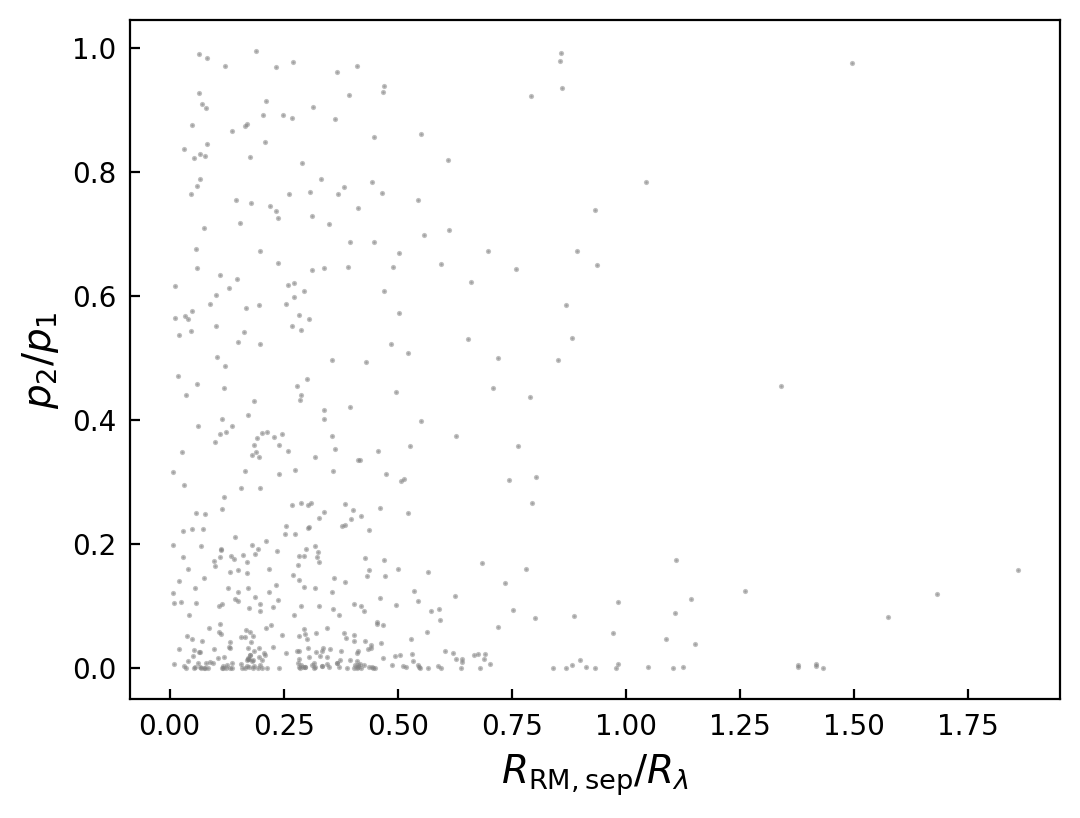

In [17]:
pbcg_miscent = redM_miscent['p_cen']

p2_over_p1 = pbcg_miscent[:,1] / pbcg_miscent[:,0]

plt.figure(figsize=(6,4.5))

plt.scatter(rrmsep_rlambda_miscent, p2_over_p1, s=0.75, alpha=0.5, c='grey')

plt.xlabel(r'$R_{\rm RM, sep} / R_\lambda$', fontsize=14)
plt.ylabel(r'$p_{2} / p_{1}$', fontsize=14)

In [16]:
# ^ this is a good plot to show

# make bins of miscentering

### Include the percentage of centered vs miscentered

bin1 = rsep_miscent <= 1e-1
bin2 = (rsep_miscent > 1e-1) & (rsep_miscent <= 3e-1)
bin3 = (rsep_miscent > 3e-1) & (rsep_miscent <= 5e-1)
bin4 = (rsep_miscent > 5e-1) & (rsep_miscent <= 7e-1)
bin5 = (rsep_miscent > 7e-1) & (rsep_miscent <= 9e-1)
bin6 = rsep_miscent > 9e-1

hm_bin1 = halos_miscent[bin1]
hm_bin2 = halos_miscent[bin2]
hm_bin3 = halos_miscent[bin3]
hm_bin4 = halos_miscent[bin4]
hm_bin5 = halos_miscent[bin5]
hm_bin6 = halos_miscent[bin6]

rm_bin1 = redM_miscent[bin1]
rm_bin2 = redM_miscent[bin2]
rm_bin3 = redM_miscent[bin3]
rm_bin4 = redM_miscent[bin4]
rm_bin5 = redM_miscent[bin5]
rm_bin6 = redM_miscent[bin6]

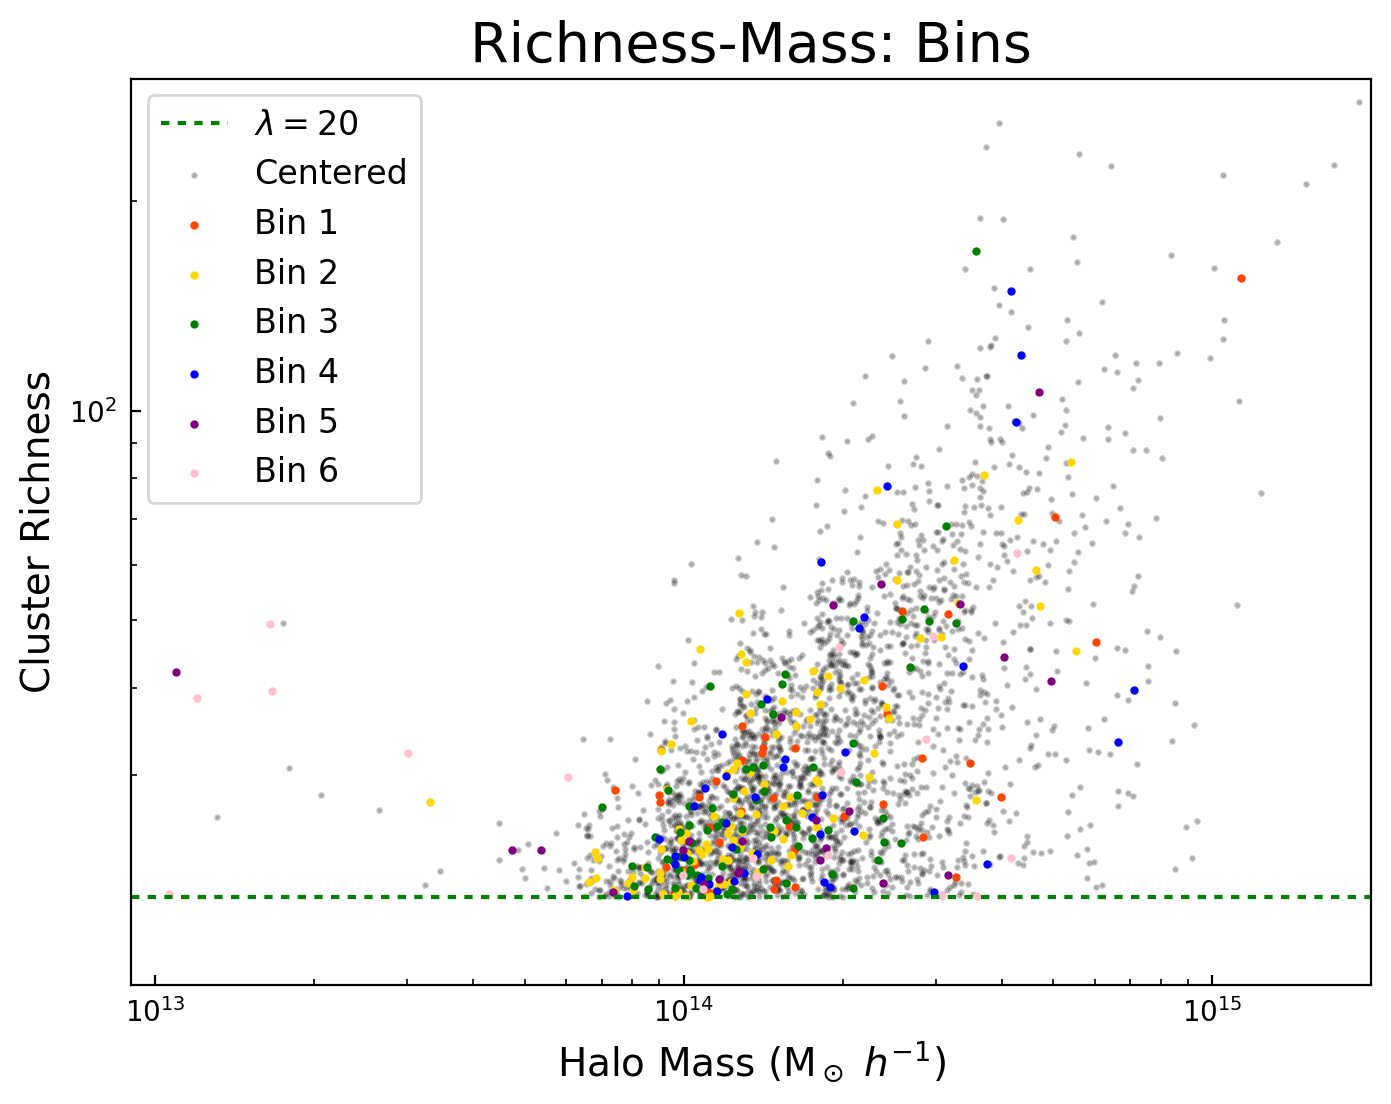

In [17]:
dotsize=4.0

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_matched[centered]['halo_mass'], redM_matched[centered]['richness'], alpha=0.2, s=2.0, c='black', label='Centered')
plt.scatter(hm_bin1['halo_mass'], rm_bin1['richness'], s=dotsize, c='orangered', label='Bin 1')
            #, label=r'$d_{\rm cmv} < 0.1$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(hm_bin2['halo_mass'], rm_bin2['richness'], s=dotsize, c='gold', label='Bin 2')
            #, label=r'$0.1$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.3$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(hm_bin3['halo_mass'], rm_bin3['richness'], s=dotsize, c='green', label='Bin 3')
            #, label=r'$0.3$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.5$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(hm_bin4['halo_mass'], rm_bin4['richness'], s=dotsize, c='blue', label='Bin 4')
            #, label=r'$0.5$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.7$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(hm_bin5['halo_mass'], rm_bin5['richness'], s=dotsize, c='purple', label='Bin 5')
            #, label=r'$0.7$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.9$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(hm_bin6['halo_mass'], rm_bin6['richness'], s=dotsize, c='pink', label='Bin 6')
            #, label=r'$0.9$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv}$')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$ $h^{-1}$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass: Bins', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

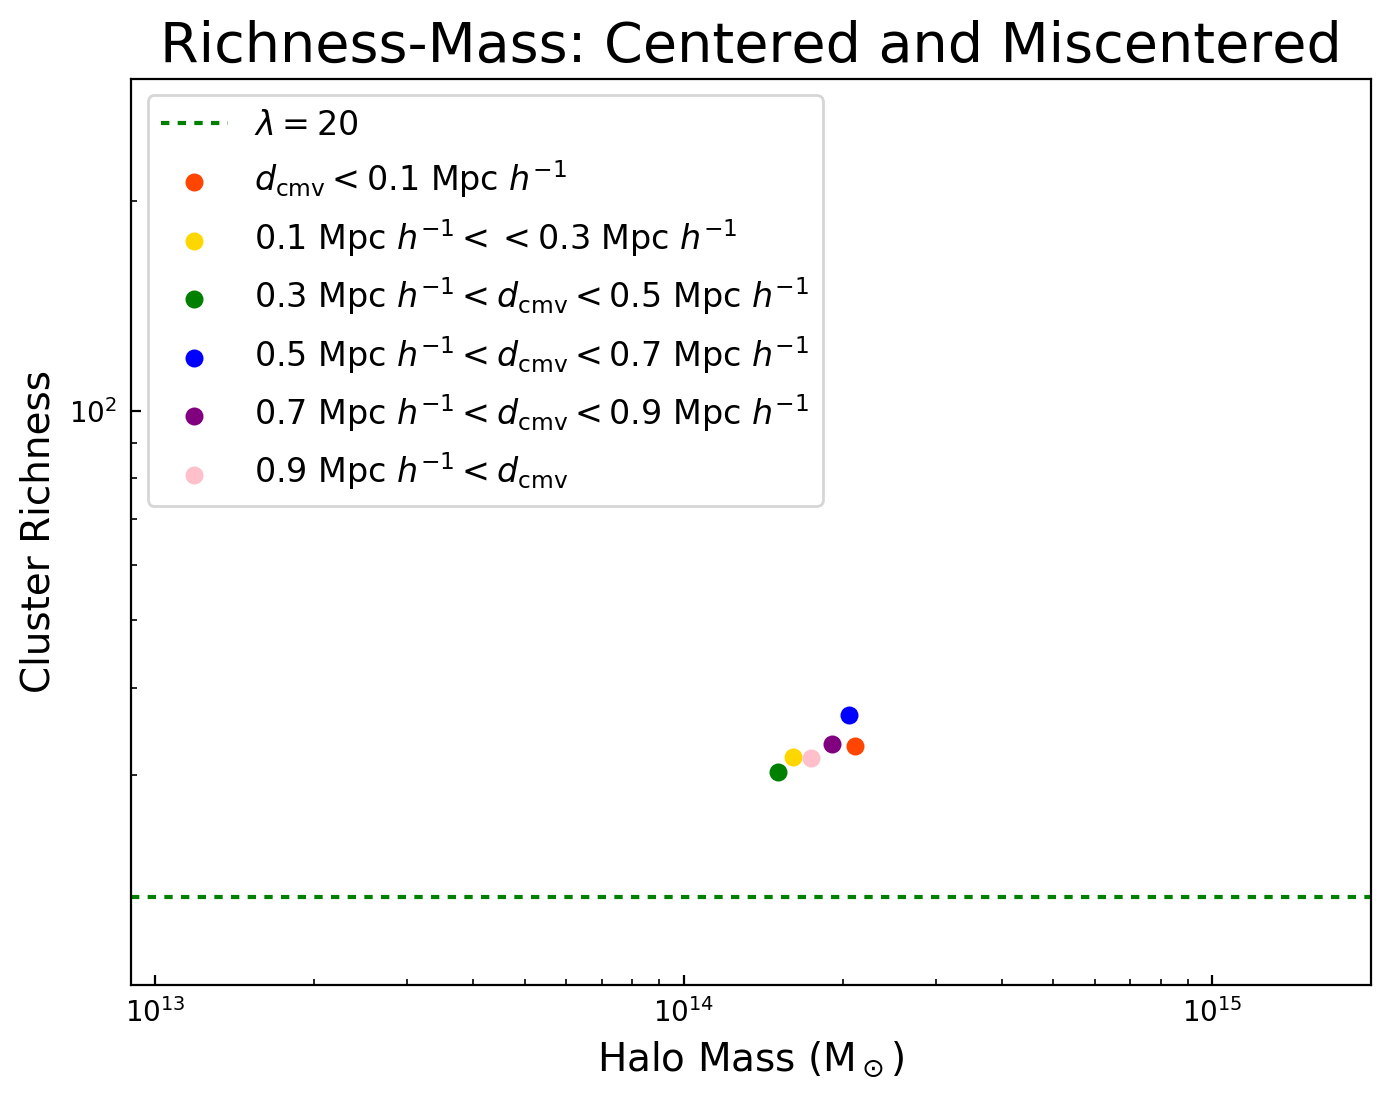

In [18]:
# ^ good plot, just make it prettier

# is halo mass in units of Mdot / h? at some point, we need to make sure we know!

dotsize=30

plt.figure(figsize=(8,6))
#plt.scatter(halos_matched[centered]['halo_mass'], redM_matched[centered]['richness'], s=0.5, c='r', label='Centered')
plt.scatter(np.mean(hm_bin1['halo_mass']), np.mean(rm_bin1['richness']), s=dotsize, c='orangered', label=r'$d_{\rm cmv} < 0.1$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(np.mean(hm_bin2['halo_mass']), np.mean(rm_bin2['richness']), s=dotsize, c='gold', label=r'$0.1$ $\rm{Mpc}$ $h^{-1} <  < 0.3$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(np.mean(hm_bin3['halo_mass']), np.mean(rm_bin3['richness']), s=dotsize, c='green', label=r'$0.3$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.5$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(np.mean(hm_bin4['halo_mass']), np.mean(rm_bin4['richness']), s=dotsize, c='blue', label=r'$0.5$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.7$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(np.mean(hm_bin5['halo_mass']), np.mean(rm_bin5['richness']), s=dotsize, c='purple', label=r'$0.7$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv} < 0.9$ $\rm{Mpc}$ $h^{-1}$')
plt.scatter(np.mean(hm_bin6['halo_mass']), np.mean(rm_bin6['richness']), s=dotsize, c='pink', label=r'$0.9$ $\rm{Mpc}$ $h^{-1} < d_{\rm cmv}$')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass: Centered and Miscentered', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [37]:
print('Bin 1:', np.mean(hm_bin1['halo_mass'])/ 1e14, np.std(hm_bin1['halo_mass']) / 1e14, np.mean(rm_bin1['richness']), np.std(rm_bin1['richness']))
print('Bin 2:', np.mean(hm_bin2['halo_mass'])/ 1e14, np.std(hm_bin2['halo_mass'])/ 1e14, np.mean(rm_bin2['richness']), np.std(rm_bin2['richness']))
print('Bin 3:', np.mean(hm_bin3['halo_mass'])/ 1e14, np.std(hm_bin3['halo_mass'])/ 1e14, np.mean(rm_bin3['richness']), np.std(rm_bin3['richness']))
print('Bin 4:', np.mean(hm_bin4['halo_mass'])/ 1e14, np.std(hm_bin4['halo_mass'])/ 1e14, np.mean(rm_bin4['richness']), np.std(rm_bin4['richness']))
print('Bin 5:', np.mean(hm_bin5['halo_mass'])/ 1e14, np.std(hm_bin5['halo_mass'])/ 1e14, np.mean(rm_bin5['richness']), np.std(rm_bin5['richness']))
print('Bin 6:', np.mean(hm_bin6['halo_mass'])/ 1e14, np.std(hm_bin6['halo_mass'])/ 1e14, np.mean(rm_bin6['richness']), np.std(rm_bin6['richness']))

Bin 1: 2.113876870185894 1.836104717284754 32.958225 21.45657
Bin 2: 1.6128713485523487 0.9710197240937439 31.8777 13.732999
Bin 3: 1.5104421804669794 0.6526579555624696 30.268812 19.03648
Bin 4: 2.0572644917096032 1.4440645657536875 36.59792 27.266855
Bin 5: 1.9127086846317376 1.2672097863576242 33.22192 18.998869
Bin 6: 1.740558120761121 1.3652861194535444 31.694416 12.118762


In [19]:
# ^ make this into a table, and use np.std to get error bars

print('Bin 1:', np.size(hm_bin1['halo_mass']), 'pairs')
print('Bin 2:', np.size(hm_bin2['halo_mass']), 'pairs')
print('Bin 3:', np.size(hm_bin3['halo_mass']), 'pairs')
print('Bin 4:', np.size(hm_bin4['halo_mass']), 'pairs')
print('Bin 5:', np.size(hm_bin5['halo_mass']), 'pairs')
print('Bin 6:', np.size(hm_bin6['halo_mass']), 'pairs')

Bin 1: 42 pairs
Bin 2: 107 pairs
Bin 3: 72 pairs
Bin 4: 41 pairs
Bin 5: 24 pairs
Bin 6: 19 pairs


| Bin | Comoving Distance Separation ($\rm{Mpc}$ $h^{-1}$) | Average Halo Mass ($10^{14}$ ${\rm M}_\odot$)| Average Cluster Richness |
| --- | --- | --- | --- |
| 1 | $d_{\rm cmv} < 0.1$ | $2.11 \pm 1.83$ | $33.0 \pm 21.5$ |
| 2 | $0.1 < d_{\rm cmv} < 0.3$ | $1.61 \pm 0.971$ | $31.9 \pm 13.7$ |
| 3 | $0.3 < d_{\rm cmv} < 0.5$ | $1.51 \pm 0.653$ | $30.3 \pm 19.0$ |
| 4 | $0.5 < d_{\rm cmv} < 0.7$ | $2.05 \pm 1.44$ | $36.6 \pm 27.3$ |
| 5 | $0.7 < d_{\rm cmv} < 0.9$ | $1.91 \pm 1.27$ | $33.2 \pm 19.0$ |
| 6 | $0.9 < d_{\rm cmv}$ | $1.74 \pm 1.37$ | $31.7 \pm 12.1$ |

### References (so far)

Allen S. W., Evrard A. E., Mantz A. B. (2011), "Cosmological Parameters from Observations of Galaxy Clusters," *ARA&A* **49**: 409-470. arXiv:1103.4829

Zhang Z., *et al.* (2020), "Effects of Cluster Triaxiaility on DES Stacked Weak Lensing Analysis," *MNRAS* **(Vol. number)**: 1-19. arXiv: (idk yet)

In [ ]:
# for navigating directories and reading HDF5 files
import os
import dask as da
import dask.dataframe as dd
import h5py